# Introduction
This notebook is a result of a master's project in supervised learning.  Given the choice of topic, I initally veered directly towards climate change oriented work.  However, I stumbed upon the stop and frisk questionnaire dataset while perusing the NYC Open Data site.  After comparing some of the previous analysis from 2016, I found the line of inquiry much more compelling and fascinating from a social impact point of view.  

With an initial perusal of the data via pivot tables, I was just shocked that there are a disturbing number of disproportionate stops of black children and black individuals at large.  

Racially biased policing is a phrase that's almost redundant for the anti-racist individuals, so I'm not uncovering anything new here.  

But are these findings statistically significant?  Is this dataset truly representative of stop and frisk? Is there anything here in the data that might improve the lives of our NYC neighbors?  I may be asking these questions (and assuming their answers) as an average NYC resident, but I hope to answer them rigorously as a data scientist and as a machine learning engineer.  

As such, I decided to focus on a 2024 exploration of the NYPD generated dataset to find latent truths hidden in the data and attempt to train a predictive model which helps hold the NYPD accountable, but more importantly to provide tooling to aid those who are unjustly targeted.

## A Brief Aside for unexpected empathy
Having turned the corner on much of the EDA, I suddenly understand why officers are so reluctant to take actions because of the "paperwork".  

At 81 discrete data points which need to be vetted and validated, a couple of stop and frisk interactions could easily take up an entire afternoon of data entry.  I say this after seeing the [astronomical stop and frisk numbers prior to 2017](https://datacollaborativeforjustice.org/dashboard-sqf/) and reviewing the data from the same period.  There's orders of magnitude less data collected from that period despite a stop rate of up to 25k stops / 100,000 persons, or ~600,000 total stops in 2016 vs the ~25,000 stops in 2024*.  

One of the primary drivers of keeping these rates as low as they are might very well be the raw data entry time required to process that many events.

But, I digress....

# EDA (Exploratory Data Analysis)
EDA is a method of exploring through a given set of data, finding and cleaning outliers, and ultimately preparing the data for ML model training.  In contrast to many public/open datasets, this dataset is fairly clean and consistent, possibly because of legal oversight.  

Regardless, I will thankfully be able to focus more on analyzing the data than fixing and cleaning it.

In [51]:
# Import all the things...
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [52]:
null_strings = ['(null)','#N/A', 'NA', '?', '', ' ', '&&', 'nan']

raw_df = pd.read_csv('./data/sqf-2024.csv',dtype={
        'STOP_FRISK_DATE': 'object',  # Keep as string
        'STOP_FRISK_TIME': 'object'   # Keep as string
    },
    na_values=null_strings,  # Standardize nulls
    low_memory=False)
raw_df.head()

,STOP_ID,STOP_FRISK_DATE,STOP_FRISK_TIME,YEAR2,MONTH2,DAY2,STOP_WAS_INITIATED,ISSUING_OFFICER_RANK,ISSUING_OFFICER_COMMAND_CODE,SUPERVISING_OFFICER_RANK,...,SUSPECT_OTHER_DESCRIPTION,STOP_LOCATION_PRECINCT,STOP_LOCATION_SECTOR_CODE,STOP_LOCATION_APARTMENT,STOP_LOCATION_FULL_ADDRESS,STOP_LOCATION_STREET_NAME,STOP_LOCATION_X,STOP_LOCATION_Y,STOP_LOCATION_PATROL_BORO_NAME,STOP_LOCATION_BORO_NAME
0,279772561,2024-01-01,01:58:00,2024,January,Monday,Based on Self Initiated,PO,46,SGT,...,NaN,46.0,A,NaN,1775 CLAY AVE,CLAY AVE,1010576.0,247603.0,PBBX,BRONX
1,279772564,2024-01-01,00:48:00,2024,January,Monday,Based on Self Initiated,PO,120,SGT,...,BLACK HOODIE SWEATSHIRT,67.0,D,NaN,4515 FARRAGUT RD,FARRAGUT RD,1002798.0,171482.0,PBBS,BROOKLYN
2,279772565,2024-01-01,01:10:00,2024,January,Monday,Based on Radio Run,PO,871,SGT,...,SCAR ON LIP,68.0,D,NaN,NaN,NaN,977764.0,170616.0,PBBS,BROOKLYN
3,279772566,2024-01-01,01:10:00,2024,January,Monday,Based on Radio Run,PO,871,SGT,...,RED JACKET/ RED HAT,68.0,D,NaN,NaN,NaN,977764.0,170616.0,PBBS,BROOKLYN
4,279772567,2024-01-01,01:10:00,2024,January,Monday,Based on Radio Run,PO,871,SGT,...,BLACK JACKET,68.0,D,NaN,NaN,NaN,977764.0,170616.0,PBBS,BROOKLYN


## And maybe I spoke too soon
As this dataset is pretty messy under the hood when it comes to specific datatypes.  This is relatively fine for human based consumption, but it will throw our model for a loop down the line during training.  As such, I'll first trim down the number of columns based on sparsity or irrelevance, and categorize them for uniform standardization.

In [53]:
# We have a number of broken columns which should by integer based, but contain null strings as well.  We'll clean those up if they make the final cut...
# broken_columns = [63,72,77,78]
# for v in broken_columns:
#     print(raw_df.columns[v])


# I'll come back to these columns later, but these will be transformed/hot-encoded later for training
# I'm omitting any background or suspects actions as those values should show up within the reason for the stop field, e.g.
# I will skip SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG because the corresonding rows have a criminal possession of a weapon reason already

categorical_columns_to_be_encoded = ['STOP_WAS_INITIATED']

column_categories = {
    'datetime': ['STOP_FRISK_DATE'],
    'numeric': ['STOP_ID', 'OBSERVED_DURATION_MINUTES', 'STOP_DURATION_MINUTES', 'SUSPECT_REPORTED_AGE',	'SUSPECT_WEIGHT', 'STOP_LOCATION_X',
                'STOP_LOCATION_Y'],
    'string': ['MONTH2', 'STOP_WAS_INITIATED', 'ISSUING_OFFICER_RANK', 'SUPERVISING_OFFICER_RANK', 'JURISDICTION_DESCRIPTION', 'SUSPECT_ARREST_OFFENSE',
               'SUMMONS_OFFENSE_DESCRIPTION', 'SUSPECTED_CRIME_DESCRIPTION',  'DEMEANOR_OF_PERSON_STOPPED', 'SUSPECT_SEX', 
               'SUSPECT_RACE_DESCRIPTION', 'SUSPECT_BODY_BUILD_TYPE', 'SUSPECT_OTHER_DESCRIPTION','STOP_LOCATION_BORO_NAME'
    ],
    'boolean': ['OFFICER_EXPLAINED_STOP_FLAG', 'OTHER_PERSON_STOPPED_FLAG', 'SUSPECT_ARRESTED_FLAG',
               'SUMMONS_ISSUED_FLAG', 'OFFICER_IN_UNIFORM_FLAG', 'FRISKED_FLAG',
               'SEARCHED_FLAG', 'ASK_FOR_CONSENT_FLG', 'CONSENT_GIVEN_FLG', 'OTHER_CONTRABAND_FLAG', 'FIREARM_FLAG', 'KNIFE_CUTTER_FLAG',
               'OTHER_WEAPON_FLAG', 'WEAPON_FOUND_FLAG', 'PHYSICAL_FORCE_CEW_FLAG', 'PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG', 'PHYSICAL_FORCE_HANDCUFF_SUSPECT_FLAG',
               'PHYSICAL_FORCE_OC_SPRAY_USED_FLAG', 'PHYSICAL_FORCE_OTHER_FLAG', 'PHYSICAL_FORCE_RESTRAINT_USED_FLAG', 'PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG',
               'PHYSICAL_FORCE_WEAPON_IMPACT_FLAG', 'SEARCH_BASIS_ADMISSION_FLAG',	'SEARCH_BASIS_CONSENT_FLAG',	'SEARCH_BASIS_HARD_OBJECT_FLAG',	
               'SEARCH_BASIS_INCIDENTAL_TO_ARREST_FLAG', 'SEARCH_BASIS_OTHER_FLAG',	'SEARCH_BASIS_OUTLINE_FLAG'],
    # One offs/unique cols
    'height': ['SUSPECT_HEIGHT'],
    'hours': ['STOP_FRISK_TIME'],
}
columns_to_keep = [column for category in column_categories.values() for column in category] 


def clean_numeric(df, cols):
    for col in cols:
        df[col] = (
            df[col]
            # .replace(null_strings, np.nan)
            .apply(pd.to_numeric, errors='coerce')  # Coerce non-numeric to NaN
            .astype('Int64')  # Convert to nullable integer
        )
    return df

def clean_string(df, cols):
    for col in cols:
        df[col] = (
            df[col]
            .astype(str)
            .replace(null_strings, np.nan)
            .str.strip()  # Remove leading/trailing whitespace
        )
    return df

def clean_boolean(df, cols):
    pd.set_option('future.no_silent_downcasting', True) # Future proofing
    for col in cols:
        value_counts = df[col].value_counts()
        # These are boolean fields, so we shouldn't see anything other than two options, whether null or false, but never both.
        if len(value_counts) < 2:  # Force features with only 'Y' values to have 'N' values instead of nulls
            df[col] = df[col].replace([np.nan], 'N')
        df[col] = (
            df[col]
            # .replace(null_strings, False)
            .str.strip()  # Remove leading/trailing whitespace
            .replace({'Y': True, 'N': False, '1': True, '0': False}).infer_objects(copy=False)
            .astype('boolean')  # Pandas' nullable boolean
        )
        num_null_values = df[col].isna().sum()
        assert num_null_values >= 0 if col in ['ASK_FOR_CONSENT_FLG','CONSENT_GIVEN_FLG'] else num_null_values == 0, f"{col}: {num_null_values} <NA> values"
    return df

def clean_datetime(df, cols):
    date_formats = {
        'STOP_FRISK_DATE': '%Y-%M-%d',  # YYYY-MM-DD
    }
    for col in cols:
        df[col] = pd.to_datetime(df[col], format=date_formats.get(col), errors='coerce')
    return df

def clean_hours(df, cols):
    for col in cols:
        df[col] = df[col].str.split(':').str[0]  # Parse out hours from HH:MM:SS format...
        df[col] = pd.to_numeric(df[col],  errors='coerce')
    return df

def clean_height(df, cols, null_strings=null_strings):
    for col in cols:
        df[col] = (
            df[col]
            .astype(str)
            # .replace(null_strings, np.nan)
            .str.extract(r'^(\d+)\.?(\d+)?$')  # Extract feet and inches
            .apply(lambda x: (int(x[0]) * 30.48) + (int(x[1]) * 2.54) if pd.notna(x[0]) else np.nan, axis=1)
            .round()
            .astype('Int64')
        )
    return df    
def filter_bad_data(df):
    # Completely arbitrary cut off for bad data, but I'll assume any ages less than 6 to be errors
    # Similarly, this may remove real, valid data for stops of developmentally disabled persons
    df = df.dropna(subset=['SUSPECT_REPORTED_AGE', 'SUSPECT_HEIGHT', 'SUSPECT_RACE_DESCRIPTION'])
    df = df[df['SUSPECT_REPORTED_AGE'] >= 6] 
    df = df[df['SUSPECT_HEIGHT'].between(90, 250)] # Min heights of 3ftm to a max of ~8ft
    return df

def clean_data(df, categories, columns_to_keep=columns_to_keep):
    new_df = df[columns_to_keep].copy()
    new_df = clean_datetime(new_df, categories['datetime'])
    new_df = clean_hours(new_df, categories['hours'])
    new_df = clean_string(new_df, categories['string'])
    new_df = clean_numeric(new_df, categories['numeric'])
    new_df = clean_boolean(new_df, categories['boolean'])
    new_df = clean_height(new_df, categories['height'])
    new_df = filter_bad_data(new_df)
    return new_df
cleaned_df = clean_data(raw_df, column_categories)
print(f'There is approximately {len(cleaned_df)/ len(raw_df)}% of the original data after cleaning')
# cleaned_df.head(20)


There is approximately 0.7996927440321437% of the original data after cleaning


## Ongoing Assumptions
Cleaning the data has been more laborious than expected, but I wanted to explicitly call out my subjective modifications.  In particular, I've noted that I'm omitting a number of columns up front due to sparcity (i.e. not enough data) and high correlation/duplicative values (WEAPON_FOUND_FLAG overlaps with the various arrest reason flags like SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG) that will throw off future training.

Similarly, a few of the boolean/flag fields actually contain three types of values due to null strings rather than the expected two.  Initially I was going to assume a false value for all null values here, but I felt it would alter the data too much/not provide enough benefits to modify those values given what they represent.  For transparency, the flags are ASK_FOR_CONSENT_FLG and CONSENT_GIVEN_FLG, with null values representing ~2.49% and 12.26% respectively.

Conversely, there are a number of flag fields which only contain Y values, so I'll be assuming that those null/missing values are indeed false.

In [54]:
# Given the range of clerical/data entry errors in the dataset, 
#   I wanted to filter out values too far outside the norm to ensure accurate exaluations of children facing cases.
def is_plausible_child(row):
    age = row['SUSPECT_REPORTED_AGE']
    height = row['SUSPECT_HEIGHT']
    
    if age >= 18:
        return True
    # Approximate CDC growth chart percentiles (translates roughly to heights of 92cm-120cm for 6 year olds, 139-210cm)
    expected_min = 2.5*age + 77  # ~1st percentile
    expected_max = 6.5*age + 100  # ~99th percentile
    
    return (height >= expected_min) & (height <= expected_max)

plausible_df = cleaned_df[
    (cleaned_df.apply(is_plausible_child, axis=1))
]
len(plausible_df) / len(cleaned_df)
print(f'{len(plausible_df) / len(cleaned_df)}% of data remains after age-height validation')
# 2.5*6 + 77, 2.5*17 + 77, 6.5*6+100, 6.5*17+100

0.999704448056746% of data remains after age-height validation


## Spar-city, here we come
We can see from the vast differences in null rates between the datasets that these flag features are incredibly sparse overall, so normalizing them enables usage of a much larger number of these fields.  That said, we still have some outlier features that I'll consider dropping as we more forwards, specifically weight.

Until then, let's just explore the data as is.

In [55]:
def sparsity_report(df):
    sparsity_report = pd.DataFrame({
        'column': df.columns,
        'null_rate': df.isnull().mean(),
        'unique_values': df.nunique()
    }).sort_values('null_rate', ascending=False)

    print(sparsity_report[['null_rate', 'unique_values']].head(20))
sparsity_report(raw_df)
sparsity_report(plausible_df)

                                                    null_rate  unique_values
PHYSICAL_FORCE_OC_SPRAY_USED_FLAG                    0.999961              1
PHYSICAL_FORCE_WEAPON_IMPACT_FLAG                    0.999567              1
ID_CARD_IDENTIFIES_OFFICER_FLAG                      0.999015              1
SUSPECTS_ACTIONS_IDENTIFY_CRIME_PATTERN_FLAG         0.995234              1
PHYSICAL_FORCE_CEW_FLAG                              0.995234              1
SUSPECTS_ACTIONS_DRUG_TRANSACTIONS_FLAG              0.991807              1
VERBAL_IDENTIFIES_OFFICER_FLAG                       0.987079              1
SUSPECTS_ACTIONS_LOOKOUT_FLAG                        0.987001              1
SHIELD_IDENTIFIES_OFFICER_FLAG                       0.984952              1
OTHER_WEAPON_FLAG                                    0.983771              1
SEARCH_BASIS_ADMISSION_FLAG                          0.981092              1
PHYSICAL_FORCE_OTHER_FLAG                            0.976404              1

In [56]:
import geopandas as gpd
from shapely.geometry import Point
from pyproj import Transformer

def stateplane_to_latlon(x, y):
    """Convert NY State Plane (ft) coordinates to WGS84 lat/lon"""
    transformer = Transformer.from_crs(2263, 4326, always_xy=True)  # NAD83(ft) → WGS84
    # Note: transform takes (x,y) = (easting,northing) and returns (lon,lat)
    lon, lat = transformer.transform(x, y)
    return pd.Series({'lat': lat, 'lon': lon})

# Only process rows with valid coordinates
coord_mask = (plausible_df['STOP_LOCATION_X'].notna() & 
              plausible_df['STOP_LOCATION_Y'].notna())
coord_df = plausible_df[coord_mask].copy()

# Convert coordinates (this may take a minute for large datasets)
coord_df[['lat', 'lon']] = coord_df.apply(
    lambda row: stateplane_to_latlon(row['STOP_LOCATION_X'], row['STOP_LOCATION_Y']),
    axis=1
)
# 1. Check CRS of loaded NTA file
nta = gpd.read_file('./data/2020 Neighborhood Tabulation Areas (NTAs)_20250514.geojson')
print(f"NTA CRS: {nta.crs}")

# 2. Ensure NTA is in EPSG:4326
if nta.crs != "EPSG:4326":
    nta = nta.to_crs("EPSG:4326")

# 3. Check for and fix any invalid geometries
invalid_geometries = ~nta.is_valid
if invalid_geometries.any():
    print(f"Found {invalid_geometries.sum()} invalid geometries in NTA data")
    nta['geometry'] = nta.geometry.buffer(0)  # Quick fix for invalid geometries

# 4. Use 'intersects' predicate instead of 'within'
geometry = [Point(xy) for xy in zip(coord_df['lon'], coord_df['lat'])]
stops_gdf = gpd.GeoDataFrame(coord_df, geometry=geometry, crs="EPSG:4326")

# Spatial join with diagnostic information
print(f"Stops GDF CRS: {stops_gdf.crs}")
print(f"NTA CRS: {nta.crs}")

# Check a sample of point coordinates to verify they look reasonable
print("Sample of transformed coordinates:")
print(stops_gdf[['lat', 'lon']].head())

# Check for points that might be outside NYC bounds
outside_nyc = stops_gdf[(stops_gdf['lat'] < 40.5) | (stops_gdf['lat'] > 41.0) | 
                        (stops_gdf['lon'] < -74.3) | (stops_gdf['lon'] > -73.7)]
print(f"Points outside expected NYC bounds: {len(outside_nyc)}")

# Try the spatial join again with the fixed geometry
stops_with_nta = gpd.sjoin(stops_gdf, nta, how='left', predicate='intersects')
unmatched = stops_with_nta[stops_with_nta.index_right.isna()]
print(f"Unmatched points: {len(unmatched)} out of {len(stops_gdf)} ({len(unmatched)/len(stops_gdf)*100:.2f}%)")


NTA CRS: EPSG:4326
Stops GDF CRS: EPSG:4326
NTA CRS: EPSG:4326
Sample of transformed coordinates:
         lat        lon
0  40.846249 -73.904848
1  40.637336 -73.933170
2  40.634976 -74.023369
3  40.634976 -74.023369
4  40.634976 -74.023369
Points outside expected NYC bounds: 4
Unmatched points: 7 out of 20265 (0.03%)


In [57]:
# Just dropping these for now given their small number
stops_with_nta = stops_with_nta.drop(unmatched.index)
unmatched = stops_with_nta[stops_with_nta.index_right.isna()]
print(f"Unmatched points remaining after cleaning: {len(unmatched)} out of {len(stops_with_nta)} ({len(unmatched)/len(stops_with_nta)*100:.2f}%)")


Unmatched points remaining after cleaning: 0 out of 20258 (0.00%)


In [58]:
# Official NYC neighborhood-to-borough mapping (as of 2024)
# Source: NYC Planning Community District Profiles
# This mapping is pretty brittle and is sensitive to ordering given the fuzzy matching from nta -> this dictionary
NEIGHBORHOOD_BOROUGH_VALIDATION = {
    # Manhattan
    "Battery Park City": "Manhattan",
    "Chelsea": "Manhattan",
    "Chinatown": "Manhattan",
    "East Harlem": "Manhattan",
    "Financial District": "Manhattan",
    "Greenwich Village": "Manhattan",
    "Harlem": "Manhattan",
    "SoHo": "Manhattan",
    "Upper East Side": "Manhattan",
    "Upper West Side": "Manhattan",
    "Central Harlem": "Manhattan",
    "West Harlem": "Manhattan",
    "Hamilton Heights": "Manhattan",
    "Manhattanville": "Manhattan",
    "Morningside Heights": "Manhattan",
    "Washington Heights": "Manhattan",
    "Inwood": "Manhattan",
    "Hell's Kitchen": "Manhattan",
    "Midtown": "Manhattan",
    "East Village": "Manhattan",
    "Gramercy": "Manhattan",
    "Kips Bay": "Manhattan",
    "Lower East Side": "Manhattan",
    "Murray Hill-Broadway Flushing": "Queens", 
    "Murray Hill": "Manhattan",
    "Broadway Flushing": "Queens",
    "NoHo": "Manhattan",
    "Nolita": "Manhattan",
    "Stuyvesant Town": "Manhattan",
    "Tribeca": "Manhattan",
    "West Village": "Manhattan",
    "Yorkville": "Manhattan",
    "Lenox Hill": "Manhattan",
    "Lincoln Square": "Manhattan",
    "Sutton Place": "Manhattan",
    "Carnegie Hill": "Manhattan",
    "Turtle Bay": "Manhattan",
    "Tudor City": "Manhattan",
    "Flatiron District": "Manhattan",
    "Hudson Yards": "Manhattan",
    "NoMad": "Manhattan",
    "Roosevelt Island": "Manhattan",
    "Two Bridges": "Manhattan",
   
    # Brooklyn
    "Bedford-Stuyvesant": "Brooklyn",
    "Bensonhurst": "Brooklyn",
    "Brooklyn Heights": "Brooklyn",
    "Bushwick": "Brooklyn",
    "Coney Island": "Brooklyn",
    "DUMBO": "Brooklyn",
    "East New York": "Brooklyn",
    "Flatbush": "Brooklyn",
    "Park Slope": "Brooklyn",
    "Williamsburg": "Brooklyn",
    "Bay Ridge": "Brooklyn",
    "Boerum Hill": "Brooklyn",
    "Borough Park": "Brooklyn",
    "Brighton Beach": "Brooklyn",
    "Brownsville": "Brooklyn",
    "Canarsie": "Brooklyn",
    "Carroll Gardens": "Brooklyn",
    "Clinton Hill": "Brooklyn",
    "Cobble Hill": "Brooklyn",
    "Crown Heights": "Brooklyn",
    "Highland Park-Cypress Hills Cemeteries (North)": "Queens",
    "Cypress Hills": "Brooklyn",
    "Highland Park": "Brooklyn",
    "Cypress Hills Cemeteries": "Queens",
    "Dyker Heights": "Brooklyn",
    "East Flatbush": "Brooklyn",
    "Fort Greene": "Brooklyn",
    "Gowanus": "Brooklyn",
    "Gravesend": "Brooklyn",
    "Greenpoint": "Brooklyn",
    "Kensington": "Brooklyn",
    "Midwood": "Brooklyn",
    "Mill Basin": "Brooklyn",
    "Ocean Hill": "Brooklyn",
    "Prospect Heights": "Brooklyn",
    "Prospect Lefferts Gardens": "Brooklyn",
    "Red Hook": "Brooklyn",
    "Sheepshead Bay": "Brooklyn",
    "Sunset Park": "Brooklyn",
    "Windsor Terrace": "Brooklyn",
    "Flatlands": "Brooklyn",
    "Marine Park": "Brooklyn",
    "Bergen Beach": "Brooklyn",
    "Sea Gate": "Brooklyn",
    "Manhattan Beach": "Brooklyn",
    "Gerritsen Beach": "Brooklyn",
    "Georgetown": "Brooklyn",
    "Starrett City": "Brooklyn",
    "Bath Beach": "Brooklyn",
   
    # Queens
    "Astoria": "Queens",
    "Flushing": "Queens",
    "Jackson Heights": "Queens",
    "Long Island City": "Queens",
    "Sunnyside": "Queens",
    "Bayside": "Queens",
    "Corona": "Queens",
    "East Elmhurst": "Queens",
    "Elmhurst": "Queens",
    "Forest Hills": "Queens",
    "Fresh Meadows": "Queens",
    "Glendale": "Queens",
    "Howard Beach": "Queens",
    "Jamaica": "Queens",
    "Kew Gardens": "Queens",
    "Little Neck": "Queens",
    "Maspeth": "Queens",
    "Middle Village": "Queens",
    "Ozone Park": "Queens",
    "Queens Village": "Queens",
    "Rego Park": "Queens",
    "Richmond Hill": "Queens",
    "Ridgewood": "Queens",
    "Rockaway Beach": "Queens",
    "Whitestone": "Queens",
    "Woodhaven": "Queens",
    "Woodside": "Queens",
    "Auburndale": "Queens",
    "Bayswater": "Queens",
    "Bellerose": "Queens",
    "Briarwood": "Queens",
    "Cambria Heights": "Queens",
    "College Point": "Queens",
    "Douglaston": "Queens",
    "Far Rockaway": "Queens",
    "Floral Park": "Queens",
    "Glen Oaks": "Queens",
    "Hollis": "Queens",
    "Hollis Hills": "Queens",
    "Jamaica Estates": "Queens",
    "Jamaica Hills": "Queens",
    "Kew Gardens Hills": "Queens",
    "Laurelton": "Queens",
    "Rosedale": "Queens",
    "South Jamaica": "Queens",
    "Springfield Gardens": "Queens",
    "St. Albans": "Queens",
    "Utopia": "Queens",
    "Queensbridge": "Queens",
    "Ravenswood": "Queens",
    "Dutch Kills": "Queens",
    "Queensbridge-Ravenswood-Dutch Kills": "Queens",
   
    # Bronx
    "Fordham": "Bronx",
    "Hunts Point": "Bronx",
    "Mott Haven": "Bronx",
    "Pelham Bay": "Bronx",
    "University Heights": "Bronx",
    "Bedford Park": "Bronx",
    "Belmont": "Bronx",
    "Castle Hill": "Bronx",
    "City Island": "Bronx",
    "Claremont Village": "Bronx",
    "Co-op City": "Bronx",
    "Concourse": "Bronx",
    "Concourse Village": "Bronx",
    "Eastchester": "Bronx",
    "Edenwald": "Bronx",
    "Fieldston": "Bronx",
    "Highbridge Park": "Manhattan",
    "Highbridge": "Bronx",
    "Kingsbridge": "Bronx",
    "Kingsbridge Heights": "Bronx",
    "Melrose": "Bronx",
    "Morris Heights": "Bronx",
    "Morris Park": "Bronx",
    "Morrisania": "Bronx",
    "Norwood": "Bronx",
    "Parkchester": "Bronx",
    "Pelham Gardens": "Bronx",
    "Pelham Parkway": "Bronx",
    "Port Morris": "Bronx",
    "Riverdale": "Bronx",
    "Soundview": "Bronx",
    "Spuyten Duyvil": "Bronx",
    "Throgs Neck": "Bronx",
    "Tremont": "Bronx",
    "Van Nest": "Bronx",
    "Wakefield": "Bronx",
    "West Farms": "Bronx",
    "Westchester Square": "Bronx",
    "Williamsbridge": "Bronx",
    "Woodlawn": "Bronx",
    "Baychester": "Bronx",
    "Allerton": "Bronx",
    "Clason Point": "Bronx",
    "Olinville": "Bronx",
    "Mount Hope": "Bronx",
    "Mount Eden-Claremont (West)": "Bronx",
    "Mount Eden": "Bronx",
    "Claremont": "Bronx",
    "Claremont Village": "Bronx",
    "Crotona Park East": "Bronx",
    "Longwood": "Bronx",
   
    # Staten Island
    "Port Richmond": "Staten Island",
    "St. George": "Staten Island",
    "Tottenville": "Staten Island",
    "Annadale": "Staten Island",
    "Arden Heights": "Staten Island",
    "Arlington": "Staten Island",
    "Arrochar": "Staten Island",
    "Bay Terrace (Staten Island)": "Staten Island",
    "Bulls Head": "Staten Island",
    "Castleton Corners": "Staten Island",
    "Charleston": "Staten Island",
    "Clifton": "Staten Island",
    "Dongan Hills": "Staten Island",
    "Eltingville": "Staten Island",
    "Emerson Hill": "Staten Island",
    "Fort Wadsworth": "Staten Island",
    "Graniteville": "Staten Island",
    "Grant City": "Staten Island",
    "Grasmere": "Staten Island",
    "Great Kills": "Staten Island",
    "Grymes Hill": "Staten Island",
    "Huguenot": "Staten Island",
    "Lighthouse Hill": "Staten Island",
    "Livingston": "Staten Island",
    "Mariners Harbor": "Staten Island",
    "Midland Beach": "Staten Island",
    "New Brighton": "Staten Island",
    "New Dorp": "Staten Island",
    "New Springville": "Staten Island",
    "Oakwood": "Staten Island",
    "Ocean Breeze": "Staten Island",
    "Old Town": "Staten Island",
    "Pleasant Plains": "Staten Island",
    "Prince's Bay": "Staten Island",
    "Randall Manor": "Staten Island",
    "Richmond Valley": "Staten Island",
    "Richmondtown": "Staten Island",
    "Rosebank": "Staten Island",
    "Rossville": "Staten Island",
    "Sandy Ground": "Staten Island",
    "Shore Acres": "Staten Island",
    "Silver Lake": "Staten Island",
    "South Beach": "Staten Island",
    "Stapleton": "Staten Island",
    "Todt Hill": "Staten Island",
    "Tompkinsville": "Staten Island",
    "Travis": "Staten Island",
    "Ward Hill": "Staten Island",
    "West New Brighton": "Staten Island",
    "Westerleigh": "Staten Island",
    "Willowbrook": "Staten Island",
    "Woodrow": "Staten Island",
    "Freshkills Park (North)": "Staten Island",
    "Freshkills Park (South)": "Staten Island",
    "Miller Field": "Staten Island",
    "Fort Hamilton": "Brooklyn",
    "Brooklyn Navy Yard": "Brooklyn",
    "Green-Wood Cemetery": "Brooklyn",
    "Barren Island-Floyd Bennett Field": "Brooklyn",
    "Prospect Park": "Brooklyn",
    "Lincoln Terrace Park": "Brooklyn",
    "Madison": "Brooklyn",
    "Bay Terrace-Clearview": "Queens",
    "St. John Cemetery": "Queens",
    "Baisley Park": "Queens",
    "Pomonok-Electchester-Hillcrest": "Queens",
    "Pomonok": "Queens",
    "Electchester": "Queens",
    "Hillcrest": "Queens",
    "Kissena Park": "Queens",
    "Forest Park": "Queens",
    "Cunningham Park": "Queens",
    "Alley Pond Park": "Queens",
    "Queensboro Hill": "Queens",
    "LaGuardia Airport": "Queens",
    "John F. Kennedy International Airport": "Queens",
    "Jacob Riis Park-Fort Tilden-Breezy Point Tip": "Queens",
    "Breezy Point-Belle Harbor-Rockaway Park-Broad Channel": "Queens",
    "Breezy Point": "Queens",
    "Belle Harbor": "Queens",
    "Rockaway Park": "Queens",
    "Broad Channel": "Queens",
    "Bronx Park": "Bronx",
    "Crotona Park": "Bronx",
    "Van Cortlandt Park": "Bronx",
    "Yankee Stadium-Macombs Dam Park": "Bronx",
    "Hutchinson Metro Center": "Bronx",
    "Central Park": "Manhattan",
    "The Battery-Governors Island-Ellis Island-Liberty Island": "Manhattan",
    "The Battery": "Manhattan",
    "Governors Island": "Manhattan",
    "Ellis Island": "Manhattan",
    "Liberty Island": "Manhattan", 
    "Randall's Island": "Manhattan"
}

def test_neighborhood_borough_mapping(joined_data):
    """Validate that all neighborhoods map to correct boroughs"""
    errors = []
    not_matched = []
    
    for _, row in joined_data.iterrows():
        nta_name = row['ntaname']
        mapped_borough = row['boroname']
        
        if pd.isna(nta_name):
            continue  # Skip null neighborhoods
        
        # Find matching neighborhood in validation dict (case-insensitive)
        matched = False
        for valid_hood, valid_borough in NEIGHBORHOOD_BOROUGH_VALIDATION.items():
            if valid_hood.lower() in nta_name.lower():
                expected_borough = valid_borough.title()  # Standardize casing
                if mapped_borough.lower() != expected_borough.lower():
                    errors.append({
                        'stop_id': row['STOP_ID'],
                        'nta_name': nta_name,
                        'mapped_borough': mapped_borough,
                        'expected_borough': expected_borough
                    })
                matched = True
                break
        
        if not matched:
            print(f"Warning: No validation rule for {nta_name}")
            not_matched.append(nta_name)
    
    return errors, not_matched

# Run the test on your joined data
validation_errors, unmatched_ntas = test_neighborhood_borough_mapping(stops_with_nta)

if validation_errors:
    print(f"Found {len(validation_errors)} borough mapping errors:")
    error_df = pd.DataFrame(validation_errors)
    # print(error_df.head(len(validation_errors)))
    
    # Calculate error rate
    total_mapped = len(stops_with_nta[stops_with_nta['ntaname'].notna()])
    error_rate = len(validation_errors) / total_mapped
    print(f"\nError rate: {error_rate:.2%}")
else:
    print("All neighborhood-borough mappings validated successfully!")

print(f"Unique missing NTAs:", set(unmatched_ntas))
# print(error_df.head(len(validation_errors)))
# error_df.head(len(validation_errors))
# 7	283275522	Highbridge Park	Manhattan	Bronx
# 8	283388400	Highbridge Park	Manhattan	Bronx

All neighborhood-borough mappings validated successfully!
Unique missing NTAs: set()


Top 10 Neighborhoods by Stop Count:
                            ntaname   boroname  stop_count
61              East Harlem (North)  Manhattan         480
27                      Brownsville   Brooklyn         467
183  Soundview-Bruckner-Bronx River      Bronx         449
134                         Melrose      Bronx         436
98                   Harlem (North)  Manhattan         426
143          Mott Haven-Port Morris      Bronx         426
145                      Mount Hope      Bronx         420
66           East New York-New Lots   Brooklyn         376
16        Bedford-Stuyvesant (East)   Brooklyn         324
31                         Canarsie   Brooklyn         322


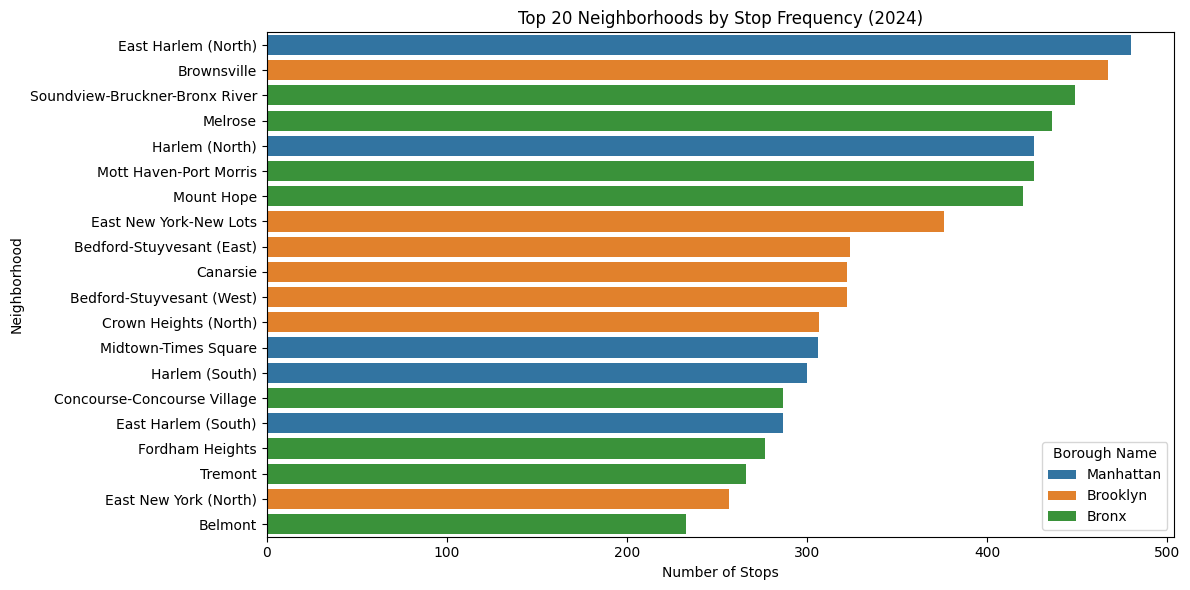

In [59]:

# Analyze stops by neighborhood
neighborhood_stops = (
    stops_with_nta.groupby(['ntaname', 'boroname'])
    .size()
    .reset_index(name='stop_count')
    .sort_values('stop_count', ascending=False)
)

print("Top 10 Neighborhoods by Stop Count:")
print(neighborhood_stops.head(10))

# %%
# Visualize stops vs population (example)
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=neighborhood_stops.head(20), 
            x='stop_count', 
            y='ntaname',
            hue='boroname',
            dodge=False)
plt.title('Top 20 Neighborhoods by Stop Frequency (2024)')
plt.xlabel('Number of Stops')
plt.ylabel('Neighborhood')
legend = plt.legend()
legend.set_title("Borough Name")
plt.tight_layout()
plt.show()
# stops_with_nta

In [60]:

mismatches = stops_with_nta[
    stops_with_nta['STOP_LOCATION_BORO_NAME'].str.lower() != 
    stops_with_nta['boroname'].str.lower()
]

# Display the mismatches
print(f"Found {len(mismatches)} borough name mismatches:")
print(mismatches[['STOP_ID', 'ntaname', 'STOP_LOCATION_BORO_NAME', 'boroname']].head())

# While I'm tempted to override these errors, I want to keep the data as unmodified as possible, so I'm dropping these
stops_with_nta = stops_with_nta.drop(labels=mismatches.index)

mismatches = stops_with_nta[
    stops_with_nta['STOP_LOCATION_BORO_NAME'].str.lower() != 
    stops_with_nta['boroname'].str.lower()
]

# Display the mismatches
print(f"After cleaning: Found {len(mismatches)} borough name mismatches:")
print(mismatches[['STOP_ID', 'ntaname', 'STOP_LOCATION_BORO_NAME', 'boroname']].head())


Found 5 borough name mismatches:
         STOP_ID                               ntaname  \
1405   281214710                       Bushwick (West)   
7097   285325419                       Bushwick (West)   
8885   286685254  Financial District-Battery Park City   
17375  292978467                       Bushwick (West)   
25303  298829337                             Ridgewood   

      STOP_LOCATION_BORO_NAME   boroname  
1405                   QUEENS   Brooklyn  
7097                   QUEENS   Brooklyn  
8885                 BROOKLYN  Manhattan  
17375                  QUEENS   Brooklyn  
25303                BROOKLYN     Queens  
After cleaning: Found 0 borough name mismatches:
Empty DataFrame
Columns: [STOP_ID, ntaname, STOP_LOCATION_BORO_NAME, boroname]
Index: []


## Aggregation at Spar-city
We can see that there still a great deal of sparse data even after the cleaning processes above.  In order to both preserve the data, but also provide more meaningful results, I will aggregate a number of columns/features.

Outcome of Stop: Categorical column with values of "ARRESTED", "SUMMONS ISSUED", and "Innocent/No Action Taken" which will be aggregated from their respective columns while innocent will be the default value in the absence of the others

Officers Used Physical Force: A Boolean feature aggregated from the many physical force features (drawing firearms, using restraint, etc.) 


In [61]:
final_df = stops_with_nta.copy()
final_df = final_df.rename(columns={"ntaname" : "NEIGHBORHOOD"})

final_df['OUTCOME_OF_STOP'] = np.select(
    condlist=[
        final_df['SUSPECT_ARRESTED_FLAG'],  
        final_df['SUMMONS_ISSUED_FLAG']
    ],
    choicelist=['Arrested', 'Summoned'],
    default='No Charges Filed'
)

PHYSICAL_FORCE_COLUMNS = [
    'PHYSICAL_FORCE_CEW_FLAG',            # Conducted Energy Weapon (Taser)
    'PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG',
    'PHYSICAL_FORCE_HANDCUFF_SUSPECT_FLAG',
    'PHYSICAL_FORCE_OC_SPRAY_USED_FLAG',  # Pepper spray
    'PHYSICAL_FORCE_OTHER_FLAG',
    'PHYSICAL_FORCE_RESTRAINT_USED_FLAG',
    # 'PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG', # Omitting as this doesn't reflect the use of force, but a warning.  Also distorts the dataset...
    'PHYSICAL_FORCE_WEAPON_IMPACT_FLAG'
]

# Create aggregated force column (True if ANY force was used)
final_df['OFFICER_USED_FORCE'] = (
    final_df[PHYSICAL_FORCE_COLUMNS]
    .fillna(False)                # Treat missing values as no force
    .any(axis=1)                  # True if any force column is True
    .astype(bool)                 # Ensure boolean dtype
)

final_df['FORCE_TYPE'] = np.select(
    [
        final_df['PHYSICAL_FORCE_WEAPON_IMPACT_FLAG'],
        final_df['PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG'],
        final_df['PHYSICAL_FORCE_CEW_FLAG'], 
        final_df['PHYSICAL_FORCE_OC_SPRAY_USED_FLAG'],
        final_df['PHYSICAL_FORCE_HANDCUFF_SUSPECT_FLAG'],
        final_df['PHYSICAL_FORCE_OTHER_FLAG'],
        # final_df['PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG'],
        final_df['PHYSICAL_FORCE_RESTRAINT_USED_FLAG']
    ],
    [
        'Weapon Impact',
        'Firearm Drawn', 
        'Taser',
        'Pepper Spray',
        'Handcuffs',
        'Other Physical Force',
        # 'Verbal Commands', 
        'Restraint Used'
    ],
    default='No Force'
)

# Verification
final_df = final_df.reset_index(drop=True)

assert len(final_df['SUSPECT_ARRESTED_FLAG']) == len(final_df)
assert len(final_df['SUMMONS_ISSUED_FLAG']) == len(final_df)
assert final_df[['OUTCOME_OF_STOP']].notna().all().all(), "Null values detected"
print(final_df[['OUTCOME_OF_STOP']].value_counts())
print(final_df[['OFFICER_USED_FORCE']].value_counts())
print(final_df[['FORCE_TYPE']].value_counts())


OUTCOME_OF_STOP 
No Charges Filed    13233
Arrested             6285
Summoned              735
Name: count, dtype: int64
OFFICER_USED_FORCE
False                 15601
True                   4652
Name: count, dtype: int64
FORCE_TYPE          
No Force                15601
Handcuffs                2994
Firearm Drawn             581
Restraint Used            493
Other Physical Force      472
Taser                     103
Weapon Impact               8
Pepper Spray                1
Name: count, dtype: int64


## For the Children
Before analyzing the dataset at large, I did want to segment off the events targeted at children.  Children represent ~19.8% of the total NYC population as of the 2020 census, yet represent 16% of the overall stops.  Given the problems of stop and frisk, this number should be 0, but let's assume that the procedure is legitimate.  Superficially, you'd expect some 1:1ish ratio for any demographic assuming that there's a constant rate of crime for all individuals.  Clearly this assumption doesn't fit reality, but for the sake of argument and statistical clarity, we will assume its true.  

Well, that leads us to the first incongruity, in that young children aren't really committing crimes at equal levels as their older counterparts.  Specifically, while we have zero cases for children under 6, we actually begin to see a great deal of stop and frisk as early as 7 years old.  So to make the numbers a bit more aligned, I will calcuate the percentage of cases for children excluding 5 years old and below for both populations.  In general, rather than representing ~20% of NYC, 6-17 year olds comprise ~14% of the city, edging them towards the terrain of being overpoliced given that they are 15% of the city, but represent 16% of the stop and frisk events. 

In [62]:
number_of_nyc_children = 1740142
number_of_children_under_5 = 475637
total_nyc_population = 8804190
percentage_of_children_in_nyc = (number_of_nyc_children ) / (total_nyc_population ) * 100
percentage_of_6_to_17_children = (number_of_nyc_children - number_of_children_under_5) / (total_nyc_population - number_of_children_under_5) * 100
print(f"6-17 year olds represent {percentage_of_6_to_17_children:.2f}% of all New Yorkers vs the percentage of all children in NYC: {percentage_of_children_in_nyc:.2f}% ")

6-17 year olds represent 15.18% of all New Yorkers vs the percentage of all children in NYC: 19.76% 


In [63]:
# For the children, prepping children specific dataframes for analysis
demographic_features = [
    'SUSPECT_REPORTED_AGE', 
    'SUSPECT_RACE_DESCRIPTION',
    'STOP_WAS_INITIATED',
    'SUSPECTED_CRIME_DESCRIPTION',
    'OFFICER_EXPLAINED_STOP_FLAG',
    'OUTCOME_OF_STOP',
    'FORCE_TYPE',
    # 'SUSPECT_HEIGHT',
    # 'SUSPECT_SEX',
    'STOP_LOCATION_BORO_NAME',
]
demographic_df = final_df[demographic_features].copy()

all_children_df = demographic_df[demographic_df['SUSPECT_REPORTED_AGE'] < 18].copy()
under_13_df = demographic_df[demographic_df['SUSPECT_REPORTED_AGE'] <= 12].copy()
under_13_df['SUSPECT_REPORTED_AGE'].value_counts()
 
print(f'{len(all_children_df)} total records of children targeted stops, where children comprise {len(all_children_df) / len(demographic_df)*100:.2f}% of all stops')

3260 total records of children targeted stops, where children comprise 16.10% of all stops


In [64]:
from pandas import DataFrame
# All the table/graph rendering code...

RACE_LABEL_OVERRIDES = {
    'AMERICAN INDIAN/ALASKAN NATIVE': "American Indian/Alaskan Native",
    "BLACK": "Black",
    "WHITE": "White",
    'BLACK HISPANIC': 'Hispanic (Black)',
    'WHITE HISPANIC': 'Hispanic (White)',
    'MIDDLE EASTERN/SOUTHWEST ASIAN': 'ME/SW Asian',
    'ASIAN / PACIFIC ISLANDER': 'Asian/PI',
}

# Create summary tables
def show_demographic_table(demo_table: DataFrame, title, index_title=""):  
    # Calculate row and column totals for percentage calcs...
    demo_table['ROW TOTAL'] = demo_table.sum(axis=1)
    col_totals = pd.DataFrame([demo_table.sum()], index=['TOTAL'])
   
    # Calculate percentages
    grand_total = demo_table['ROW TOTAL'].sum()
    col_pct = pd.DataFrame([(demo_table.sum() / grand_total * 100).round(1)], index=['% OF TOTAL'])
   
    # Combine all components
    final_table = pd.concat([demo_table, col_totals, col_pct])
    final_table.rename_axis(columns=None)
    
    # Apply styling
    # final_table.index.name = index_title
    styled = final_table.style.set_caption(title)
    
    
    # Format only numeric cells with integers (avoiding the percentage row)
    styled = styled.format('{:,}', subset=pd.IndexSlice[demo_table.index.tolist() + ['TOTAL'], :])
    
    # Format percentage row
    styled = styled.format('{:.1f}%', subset=pd.IndexSlice['% OF TOTAL', :])
    
    # Add other styling
    styled = styled.background_gradient(cmap='Blues', subset=pd.IndexSlice[demo_table.index, :])
    styled = styled.set_table_styles([
        {'selector': 'tr:nth-last-child(2)', 'props': 'border-top: 2px solid black;'},
        {'selector': 'tr:last-child', 'props': 'border-top: 1px solid black;'},
        {'selector': '.row_heading', 'props': 'text-align: left;'},
        {'selector': 'caption', 'props': 'caption-side: top; font-size: 1.2em; font-weight: bold;'}
    ])
    # styled = styled.highlight_max(axis=0, subset=pd.IndexSlice[demo_table.index, :], color='#ffeb99')
    return styled

def plot_stop_outcomes(df, n_reasons=5, figsize=(14, 8), plot_title = "Policing Outcomes by Race and Stop Reason of 6-12 Year Olds"):
    # 1. Aggregate data safely
    outcomes = (
        df.groupby(['SUSPECT_RACE_DESCRIPTION', 
                   'SUSPECTED_CRIME_DESCRIPTION', 
                   'OUTCOME_OF_STOP'])
        .size()
        .unstack()
        .fillna(0)
    )
    
    # 2. Get top reasons that actually exist in data
    valid_reasons = df['SUSPECTED_CRIME_DESCRIPTION'].value_counts().nlargest(n_reasons).index
    valid_reasons = [r for r in valid_reasons if r in outcomes.index.get_level_values(1)]
    
    # 3. Set up plot
    n_cols = min(3, len(valid_reasons))
    n_rows = (len(valid_reasons) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    
    # 4. Color palette for whatever outcomes exist
    palette = {
        'Arrested': '#e63946',
        'Summoned': '#457b9d', 
        'No Charges Filed': '#a8dadc',
        'Other': '#1d3557'  # Fallback
    }
    
    # 5. Plot each reason
    for i, reason in enumerate(valid_reasons):
        ax = axes[i]
        reason_data = outcomes.xs(reason, level='SUSPECTED_CRIME_DESCRIPTION')
        
        # Normalize and get ACTUAL existing outcomes
        reason_data = reason_data.div(reason_data.sum(axis=1), axis=0)
        existing_outcomes = [col for col in reason_data.columns if reason_data[col].sum() > 0]
        
        labels = [
            RACE_LABEL_OVERRIDES.get(race, race[:12] + '...' if len(race) > 12 else race)
            for race in reason_data.index
        ]
        
        # Dynamically plot available outcomes
        reason_data[existing_outcomes].plot(
            kind='bar',
            stacked=True,
            ax=ax,
            color=[palette.get(o, '#999999') for o in existing_outcomes],
            width=0.8
        )
        
        # Set custom labels
        ax.set_xticklabels(labels, rotation=45, ha='right')
        
        # Formatting
        ax.set_title(f"{reason[:20]}..." if len(reason) > 20 else reason, pad=10)
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.tick_params(axis='x', rotation=45)
        
        # Only show legend on first plot
        if i != 0:
            ax.get_legend().remove()
        else:
            ax.legend(title='Outcome', bbox_to_anchor=(1, 1))

    # Clean up empty subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle(plot_title, y=1.02, fontsize=14)
    plt.show()

### Glossary of Police Terms 
Most of this type of analysis is outside my wheelhouse, so we're learning about these terms together

#### Stop Initiated Codes
Surprisingly, there is no official NYPD documentation for these values that I could find, even in its data dictionary.  Moreover, these code have changed over time in the stop and frisk datasets themselves.  As such, this is the best that I could glean from searching more broadly for reader transparency.

- Based on C/W on Scene: Based upon a complaint/witness or other third party
- Based on Radio Run: Officer was dispatched to investigate by headquarters
- Based on Self Initiated:  Officer initiated the stop and frisk interaction

#### Crime Definitions
Below is a glossary of common crime categories used in NYPD stop-and-frisk data, with definitions and direct references to the relevant sections of New York State law on [nysenate.gov](https://www.nysenate.gov/legislation/laws/PEN). Each entry includes a brief definition and a markdown link to the official legislative text where available.

They are ordered by most severe to least severe

## Misdemeanors

**ASSAULT (Third Degree)**  
Causing physical injury to another person.  
[§120.00 Assault in the third degree](https://www.nysenate.gov/legislation/laws/PEN/120.00)

**MENACING (Second Degree)**  
Placing another person in fear of imminent physical injury.  
[§120.14 Menacing in the second degree](https://www.nysenate.gov/legislation/laws/PEN/120.14)

**RECKLESS ENDANGERMENT (Second Degree)**  
Recklessly creating a substantial risk of serious physical injury.  
[§120.20 Reckless endangerment in the second degree](https://www.nysenate.gov/legislation/laws/PEN/120.20)

**FORCIBLE TOUCHING**  
Intentionally touching another person in a sexual manner without consent.  
[§130.52 Forcible touching](https://www.nysenate.gov/legislation/laws/PEN/130.52)

**CRIMINAL POSSESSION OF A WEAPON (CPW) (Misdemeanor Levels)**  
Possessing certain weapons unlawfully.  
[§265.01 Criminal possession of a weapon in the fourth degree](https://www.nysenate.gov/legislation/laws/PEN/265.01)

**CRIMINAL POSSESSION OF CONTROLLED SUBSTANCE (Misdemeanor Levels)**  
Possessing small amounts for personal use.  
[§220.03 Criminal possession of a controlled substance in the seventh degree](https://www.nysenate.gov/legislation/laws/PEN/220.03)

**CRIMINAL SALE OF MARIHUANA (Misdemeanor Levels)**  
Unlawfully selling small amounts of marijuana.  
[§221.40 Criminal sale of marihuana in the fourth degree](https://www.nysenate.gov/legislation/laws/PEN/221.40) *(Repealed, but historically relevant)*

**CRIMINAL POSSESSION OF MARIHUANA (Misdemeanor Levels)**  
Unlawful possession of marijuana.  
[§221.10 Criminal possession of marihuana in the fifth degree](https://www.nysenate.gov/legislation/laws/PEN/221.10) *(Repealed, but historically relevant)*

**CRIMINAL TRESPASS (Second Degree)**  
Knowingly entering or remaining unlawfully in a dwelling.  
[§140.15 Criminal trespass in the second degree](https://www.nysenate.gov/legislation/laws/PEN/140.15)

**CRIMINAL MISCHIEF (Fourth Degree)**  
Intentionally damaging another person's property.  
[§145.00 Criminal mischief in the fourth degree](https://www.nysenate.gov/legislation/laws/PEN/145.00)

**PETIT LARCENY**  
Theft of property valued at $1,000 or less.  
[§155.25 Petit larceny](https://www.nysenate.gov/legislation/laws/PEN/155.25)

**THEFT OF SERVICES**  
Obtaining services without paying.  
[§165.15 Theft of services](https://www.nysenate.gov/legislation/laws/PEN/165.15)

**CRIMINAL POSSESSION OF STOLEN PROPERTY (CPSP) (Misdemeanor Levels)**  
Knowingly possessing stolen property valued at $1,000 or less.  
[§165.40 Criminal possession of stolen property in the fifth degree](https://www.nysenate.gov/legislation/laws/PEN/165.40)

**AUTO STRIPPING (Misdemeanor Levels)**  
Removing parts from a vehicle without the owner's permission.  
[§165.09 Auto stripping in the third degree](https://www.nysenate.gov/legislation/laws/PEN/165.09)

**UNAUTHORIZED USE OF A VEHICLE (Third Degree)**  
Using a vehicle without the owner's consent.  
[§165.05 Unauthorized use of a vehicle in the third degree](https://www.nysenate.gov/legislation/laws/PEN/165.05)

**MAKING GRAFFITI**  
Marking property with graffiti without the owner's permission.  
[§145.60 Making graffiti](https://www.nysenate.gov/legislation/laws/PEN/145.60)

**CRIMINAL POSSESSION OF FORGED INSTRUMENT (Misdemeanor Levels)**  
Possessing a forged document with intent to defraud.  
[§170.20 Criminal possession of a forged instrument in the third degree](https://www.nysenate.gov/legislation/laws/PEN/170.20)

**PROSTITUTION**  
Engaging in, agreeing to, or offering sexual conduct for a fee.  
[§230.00 Prostitution](https://www.nysenate.gov/legislation/laws/PEN/230.00)

## Felonies

**MURDER**  
Intentionally causing the death of another person.  
[§125.25 Murder in the second degree](https://www.nysenate.gov/legislation/laws/PEN/125.25)

**TERRORISM**  
Acts intended to intimidate or coerce a civilian population or influence government policy.  
[§490.25 Crime of terrorism](https://www.nysenate.gov/legislation/laws/PEN/490.25)

**RAPE**  
Engaging in sexual intercourse with another person without consent.  
[§130.35 Rape in the first degree](https://www.nysenate.gov/legislation/laws/PEN/130.35)

**ROBBERY**  
Forcibly stealing property from another by force or threat of force.  
[§160.15 Robbery in the first degree](https://www.nysenate.gov/legislation/laws/PEN/160.15)

**BURGLARY**  
Illegally entering a building with intent to commit a crime, usually theft.  
[§140.30 Burglary in the first degree](https://www.nysenate.gov/legislation/laws/PEN/140.30)

**ASSAULT (First Degree)**  
Causing serious physical injury to another person with intent.  
[§120.10 Assault in the first degree](https://www.nysenate.gov/legislation/laws/PEN/120.10)

**CRIMINAL SALE OF CONTROLLED SUBSTANCE**  
Selling illegal drugs or controlled substances.  
[§220.43 Criminal sale of a controlled substance in the first degree](https://www.nysenate.gov/legislation/laws/PEN/220.43)

**CRIMINAL POSSESSION OF CONTROLLED SUBSTANCE (Felony Levels)**  
Possessing large quantities or with intent to sell.  
[§220.16 Criminal possession of a controlled substance in the third degree](https://www.nysenate.gov/legislation/laws/PEN/220.16)

**GRAND LARCENY**  
Theft of property valued above $1,000.  
[§155.30 Grand larceny in the fourth degree](https://www.nysenate.gov/legislation/laws/PEN/155.30)

**GRAND LARCENY AUTO**  
Theft of a motor vehicle valued above $1,000.  
[§155.30(8) Grand larceny in the fourth degree](https://www.nysenate.gov/legislation/laws/PEN/155.30)

**CRIMINAL POSSESSION OF A WEAPON (CPW) (Felony Levels)**  
Possessing a firearm or other weapon unlawfully (felony levels).  
[§265.03 Criminal possession of a weapon in the second degree](https://www.nysenate.gov/legislation/laws/PEN/265.03)

**CRIMINAL POSSESSION OF STOLEN PROPERTY (CPSP) (Felony Levels)**  
Knowingly possessing stolen property valued above $1,000.  
[§165.45 Criminal possession of stolen property in the third degree](https://www.nysenate.gov/legislation/laws/PEN/165.45)

**AUTO STRIPPING (Felony Levels)**  
Removing parts from a vehicle causing damage over $1,000.  
[§165.11 Auto stripping in the first degree](https://www.nysenate.gov/legislation/laws/PEN/165.11)

---

## Felony or Misdemeanor (Depends on Circumstances)

Some crimes can be classified as either a misdemeanor or felony depending on the value involved, the presence of weapons, injury, or prior convictions:

- ASSAULT
- CRIMINAL POSSESSION OF CONTROLLED SUBSTANCE
- CRIMINAL POSSESSION OF A WEAPON (CPW)
- CRIMINAL POSSESSION OF STOLEN PROPERTY (CPSP)
- AUTO STRIPPING
- CRIMINAL POSSESSION OF FORGED INSTRUMENT
- CRIMINAL TRESPASS
- CRIMINAL MISCHIEF
- UNAUTHORIZED USE OF A VEHICLE
- CRIMINAL SALE OF MARIHUANA


In [65]:
under_13_demo_table = (
    under_13_df.groupby(['SUSPECT_REPORTED_AGE', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(under_13_demo_table, "All Stops of Children under 13 by Age and Race", 'Age / Suspect')


SUSPECT_RACE_DESCRIPTION,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
7,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8,0.0,0.0,0.0,0.0,1.0,0.0,1.0
9,0.0,1.0,0.0,0.0,0.0,0.0,1.0
10,0.0,2.0,0.0,0.0,0.0,1.0,3.0
11,1.0,11.0,2.0,0.0,3.0,3.0,20.0
12,0.0,39.0,3.0,1.0,6.0,9.0,58.0
TOTAL,1.0,53.0,5.0,1.0,11.0,13.0,84.0
% OF TOTAL,1.2%,63.1%,6.0%,1.2%,13.1%,15.5%,100.0%


## Exploring the data
In general, I will briefly analyze three slices of New Yorkers, children under 13, all children under 18, and all New Yorkers at large.  Each analysis will largely follow a loose sequence of events defined in the data, namely who initated the stop, for what reason, what type of force did the police use if any, and ultimately to what outcome for the targeted individual.

In [66]:
under_13_demo_table = (
    under_13_df.groupby(['STOP_WAS_INITIATED', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(under_13_demo_table, "What inititated the stop of Children under 13 by Age and Race")

SUSPECT_RACE_DESCRIPTION,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Based on C/W on Scene,0.0,12.0,1.0,0.0,1.0,1.0,15.0
Based on Radio Run,0.0,32.0,3.0,0.0,10.0,9.0,54.0
Based on Self Initiated,1.0,9.0,1.0,1.0,0.0,3.0,15.0
TOTAL,1.0,53.0,5.0,1.0,11.0,13.0,84.0
% OF TOTAL,1.2%,63.1%,6.0%,1.2%,13.1%,15.5%,100.0%


In [67]:
under_13_demo_table = (
    under_13_df.groupby(['SUSPECTED_CRIME_DESCRIPTION', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(under_13_demo_table, "Why Did Officers Stop Children under 13 by Age and Race")

SUSPECT_RACE_DESCRIPTION,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
ASSAULT,0.0,5.0,1.0,1.0,1.0,2.0,10.0
BURGLARY,1.0,3.0,0.0,0.0,0.0,0.0,4.0
CPW,0.0,11.0,3.0,0.0,7.0,1.0,22.0
CRIMINAL MISCHIEF,0.0,2.0,0.0,0.0,1.0,1.0,4.0
CRIMINAL TRESPASS,0.0,0.0,0.0,0.0,0.0,2.0,2.0
GRAND LARCENY,0.0,3.0,0.0,0.0,0.0,1.0,4.0
GRAND LARCENY AUTO,0.0,1.0,0.0,0.0,1.0,0.0,2.0
MENACING,0.0,3.0,1.0,0.0,0.0,0.0,4.0
OTHER,0.0,1.0,0.0,0.0,0.0,0.0,1.0
PETIT LARCENY,0.0,4.0,0.0,0.0,0.0,0.0,4.0


In [68]:
# print("Unique values in OFFICER_USED_FORCE:", under_13_df['OFFICER_USED_FORCE'].unique())
# print("Unique values in SUSPECT_RACE_DESCRIPTION:", under_13_df['SUSPECT_RACE_DESCRIPTION'].unique())


under_13_demo_table = (
    under_13_df.groupby(['FORCE_TYPE', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(under_13_demo_table, "Why Did Officers Stop Children under 13 by Age and Race")

SUSPECT_RACE_DESCRIPTION,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Firearm Drawn,0.0,1.0,0.0,0.0,0.0,1.0,2.0
Handcuffs,0.0,9.0,1.0,0.0,1.0,2.0,13.0
No Force,1.0,42.0,4.0,1.0,10.0,10.0,68.0
Restraint Used,0.0,1.0,0.0,0.0,0.0,0.0,1.0
TOTAL,1.0,53.0,5.0,1.0,11.0,13.0,84.0
% OF TOTAL,1.2%,63.1%,6.0%,1.2%,13.1%,15.5%,100.0%


In [69]:
under_13_demo_table = (
    under_13_df.groupby(['OUTCOME_OF_STOP', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(under_13_demo_table, "What Were the Outcomes of Stops of Children under 13 by Age and Race")

SUSPECT_RACE_DESCRIPTION,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Arrested,0.0,27.0,0.0,0.0,1.0,1.0,29.0
No Charges Filed,1.0,26.0,5.0,1.0,10.0,12.0,55.0
TOTAL,1.0,53.0,5.0,1.0,11.0,13.0,84.0
% OF TOTAL,1.2%,63.1%,6.0%,1.2%,13.1%,15.5%,100.0%


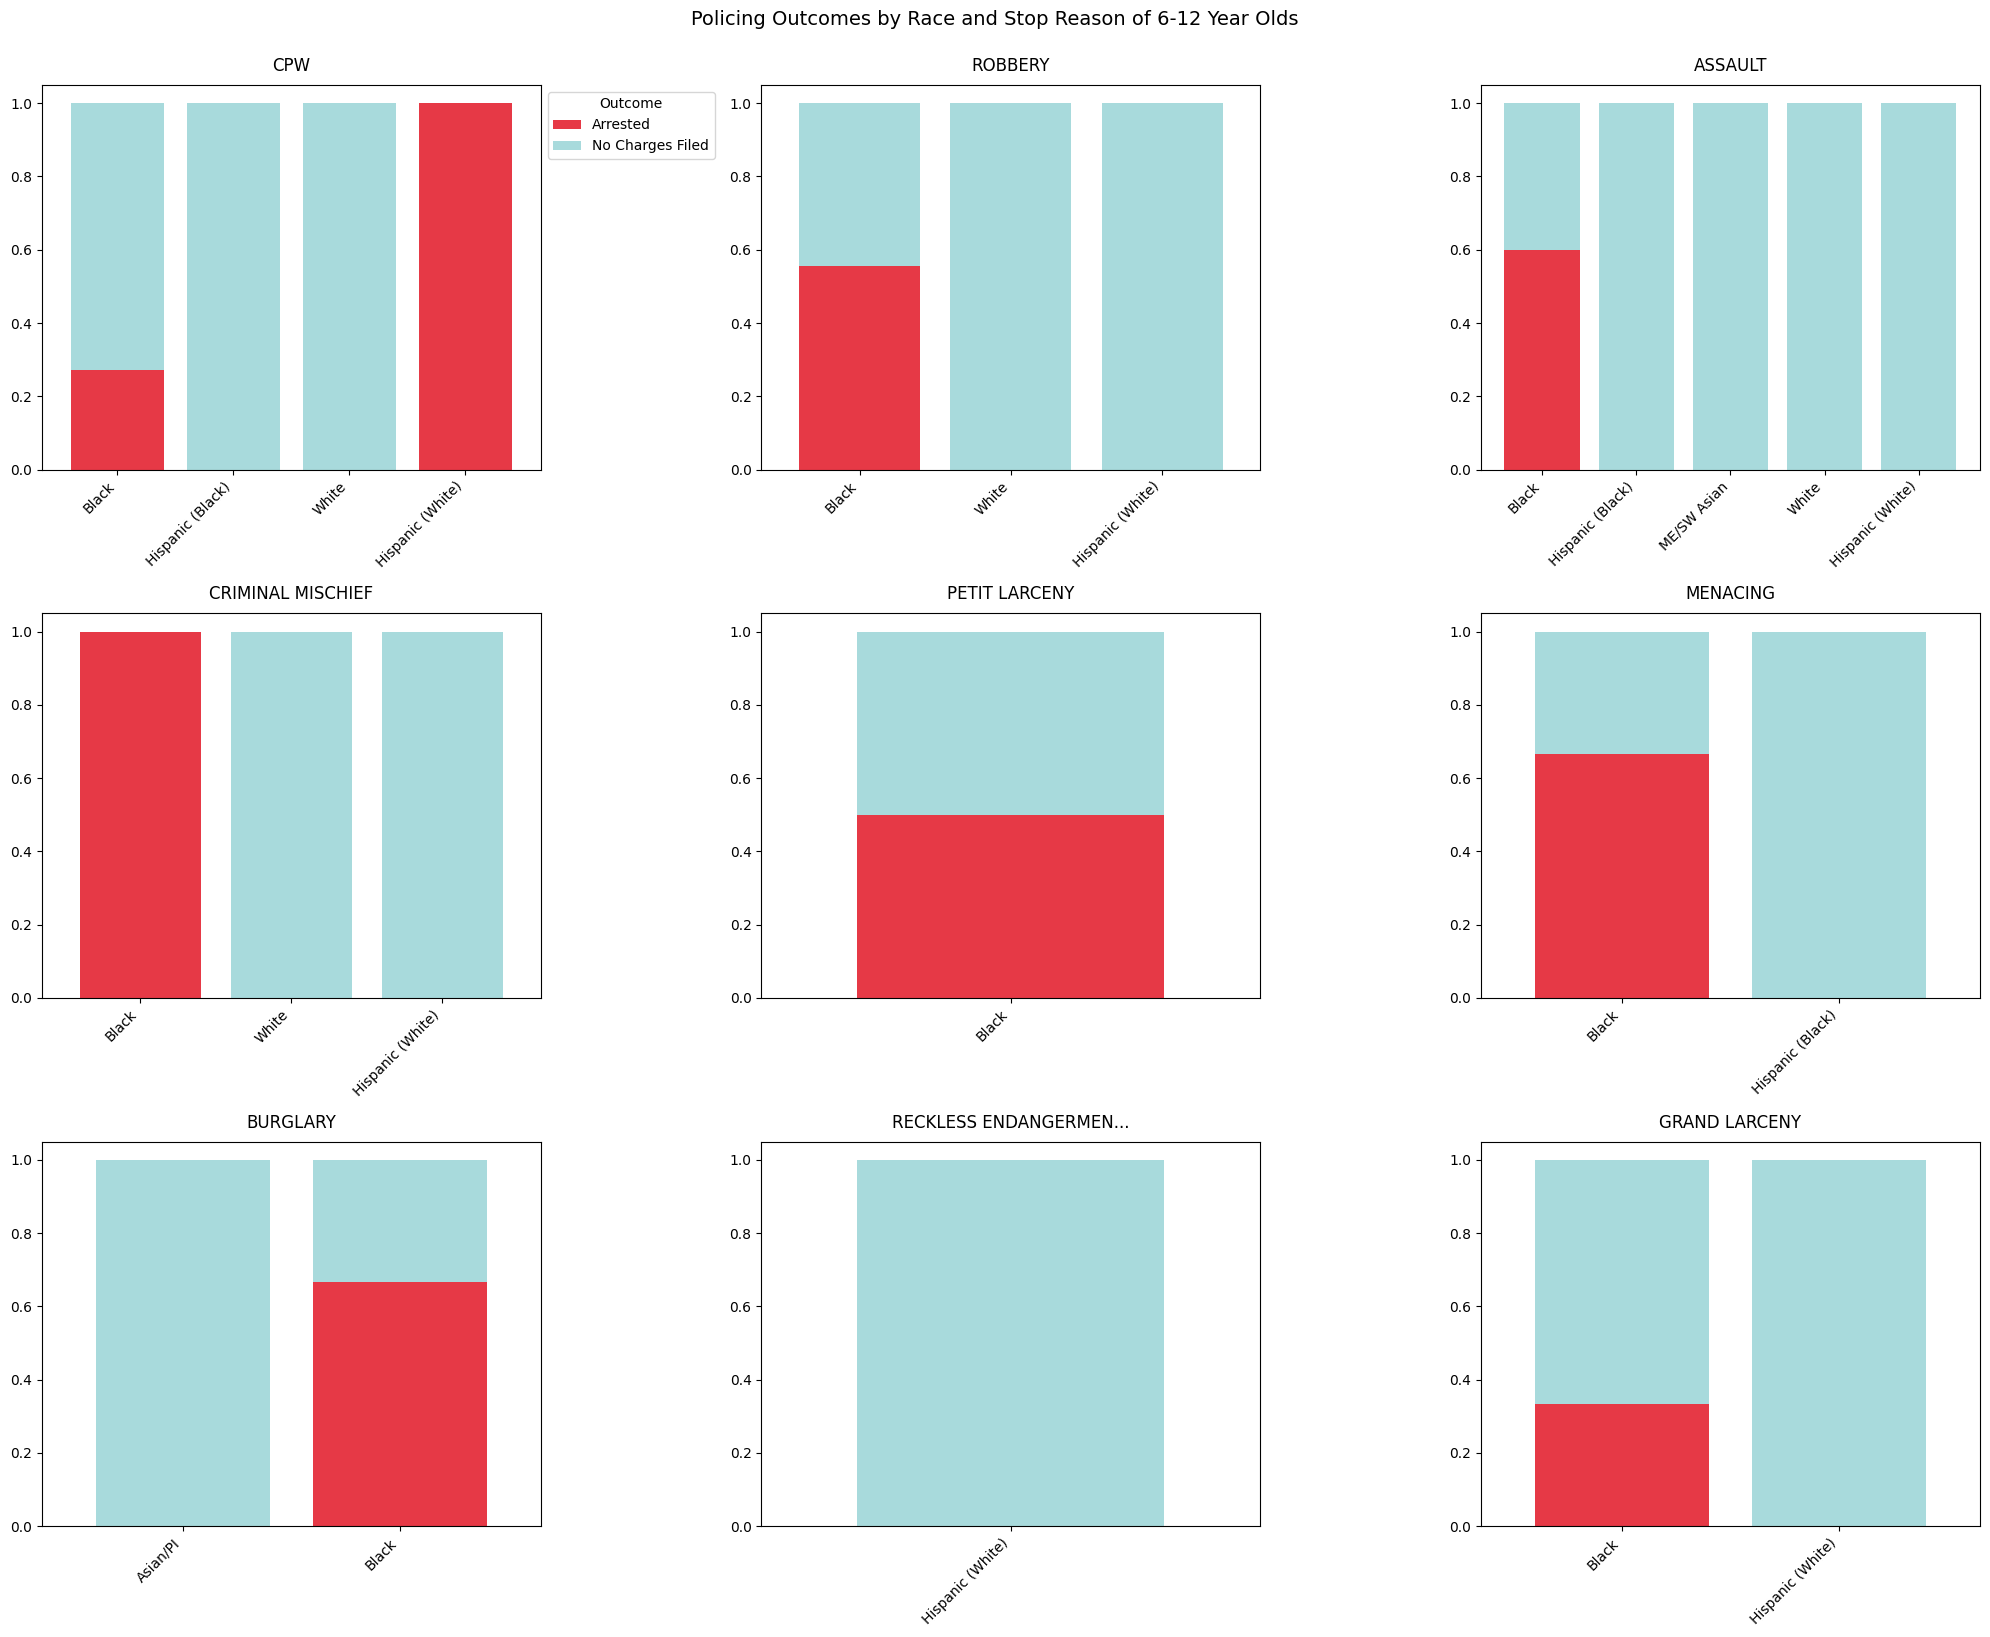

In [70]:
plot_stop_outcomes(under_13_df, figsize=(20,16), n_reasons=9)

In [71]:
# If you want to take a look at the raw data:
under_13_df

,SUSPECT_REPORTED_AGE,SUSPECT_RACE_DESCRIPTION,STOP_WAS_INITIATED,SUSPECTED_CRIME_DESCRIPTION,OFFICER_EXPLAINED_STOP_FLAG,OUTCOME_OF_STOP,FORCE_TYPE,STOP_LOCATION_BORO_NAME
348,12,BLACK,Based on C/W on Scene,ROBBERY,True,No Charges Filed,Restraint Used,BRONX
533,10,WHITE HISPANIC,Based on Radio Run,CRIMINAL MISCHIEF,True,No Charges Filed,No Force,BROOKLYN
1485,12,BLACK,Based on C/W on Scene,PETIT LARCENY,True,No Charges Filed,No Force,BRONX
2506,12,WHITE,Based on Radio Run,CPW,True,No Charges Filed,No Force,STATEN ISLAND
2507,11,WHITE,Based on Radio Run,CPW,True,No Charges Filed,No Force,STATEN ISLAND
...,...,...,...,...,...,...,...,...
19385,11,BLACK,Based on Radio Run,ASSAULT,True,No Charges Filed,No Force,BROOKLYN
19928,9,BLACK,Based on Radio Run,ROBBERY,True,Arrested,No Force,QUEENS
19929,12,BLACK,Based on Radio Run,ROBBERY,True,No Charges Filed,No Force,QUEENS
19930,12,BLACK,Based on Radio Run,ROBBERY,True,Arrested,No Force,QUEENS


### Not Off to the Best Start...
Thankfully, there are very few stops of pre-teens relative to the general population, but it is still too high.  

We've got kids as young as 7 being stopped by the police.  The earliest arrest was aged 9 for robbery.  Black and Black/Hispanic children make up the overwhelming majority of both stops as well as arrests.  They also comprise the entirety of Menacing charges and arrests, and seem to be the only children arrested for criminal mischief, assault, or robbery.  

One could certainly just come to a conclusion that these children are legitimate criminals at this age reinforcing debunked notions of super predators, but its important to call out that an arrest is not a conviction as well as the completely subjective nature of these interactions.  Any officer could use their discretion to not charge these children, as we see pretty consistently for those children possessing a lighter skin tone.


At 84 records, there's not enough statistical power to definitely prove any biases here, but there's certainly a great deal of smoke even if we can't see the fire.

But onto the Under 18 cohort...

In [72]:
all_children_demo_table = (
    all_children_df.groupby(['SUSPECT_REPORTED_AGE', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(all_children_demo_table, "All Stops of Children by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
10,0.0,0.0,2.0,0.0,0.0,0.0,1.0,3.0
11,0.0,1.0,11.0,2.0,0.0,3.0,3.0,20.0
12,0.0,0.0,39.0,3.0,1.0,6.0,9.0,58.0
13,0.0,2.0,151.0,11.0,6.0,13.0,32.0,215.0
14,2.0,2.0,329.0,28.0,4.0,32.0,77.0,474.0
15,0.0,20.0,469.0,72.0,9.0,24.0,137.0,731.0
16,0.0,8.0,564.0,75.0,7.0,26.0,157.0,837.0


In [73]:
all_children_demo_table = (
    all_children_df.groupby(['STOP_WAS_INITIATED', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(all_children_demo_table, "What inititated the stop of Children by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Based on C/W on Scene,0.0,8.0,197.0,36.0,3.0,14.0,78.0,336.0
Based on Radio Run,3.0,28.0,999.0,138.0,29.0,99.0,265.0,"1,561.0"
Based on Self Initiated,0.0,13.0,972.0,108.0,3.0,27.0,240.0,"1,363.0"
TOTAL,3.0,49.0,"2,168.0",282.0,35.0,140.0,583.0,"3,260.0"
% OF TOTAL,0.1%,1.5%,66.5%,8.7%,1.1%,4.3%,17.9%,100.0%


In [74]:
all_children_demo_table = (
    all_children_df.groupby(['SUSPECTED_CRIME_DESCRIPTION', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(all_children_demo_table, "All Stops of Children by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
ASSAULT,1.0,3.0,147.0,24.0,4.0,14.0,61.0,254.0
AUTO STRIPPIG,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
BURGLARY,0.0,2.0,47.0,10.0,1.0,16.0,11.0,87.0
CPSP,0.0,0.0,3.0,2.0,0.0,1.0,2.0,8.0
CPW,0.0,5.0,"1,058.0",113.0,15.0,37.0,235.0,"1,463.0"
CRIMINAL MISCHIEF,1.0,0.0,24.0,3.0,3.0,13.0,7.0,51.0
CRIMINAL POSSESSION OF CONTROLLED SUBSTANCE,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
CRIMINAL POSSESSION OF MARIHUANA,0.0,0.0,5.0,0.0,0.0,0.0,2.0,7.0
CRIMINAL SALE OF MARIHUANA,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
CRIMINAL TRESPASS,0.0,4.0,53.0,3.0,2.0,5.0,17.0,84.0


In [75]:
all_children_demo_table = (
    all_children_df.groupby(['FORCE_TYPE', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(all_children_demo_table, "Types of Force Used Against All Children by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Firearm Drawn,0.0,0.0,73.0,9.0,2.0,3.0,16.0,103.0
Handcuffs,0.0,9.0,342.0,51.0,2.0,15.0,82.0,501.0
No Force,3.0,38.0,"1,622.0",205.0,30.0,119.0,455.0,"2,472.0"
Other Physical Force,0.0,2.0,52.0,7.0,1.0,2.0,8.0,72.0
Restraint Used,0.0,0.0,71.0,7.0,0.0,1.0,20.0,99.0
Taser,0.0,0.0,7.0,3.0,0.0,0.0,1.0,11.0
Weapon Impact,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
TOTAL,3.0,49.0,"2,168.0",282.0,35.0,140.0,583.0,"3,260.0"
% OF TOTAL,0.1%,1.5%,66.5%,8.7%,1.1%,4.3%,17.9%,100.0%


In [76]:
all_children_demo_table = (
    all_children_df.groupby(['OUTCOME_OF_STOP', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(all_children_demo_table, "Outcome of Stops of All Children by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Arrested,1.0,19.0,752.0,105.0,9.0,44.0,176.0,"1,106.0"
No Charges Filed,2.0,27.0,"1,362.0",166.0,25.0,93.0,381.0,"2,056.0"
Summoned,0.0,3.0,54.0,11.0,1.0,3.0,26.0,98.0
TOTAL,3.0,49.0,"2,168.0",282.0,35.0,140.0,583.0,"3,260.0"
% OF TOTAL,0.1%,1.5%,66.5%,8.7%,1.1%,4.3%,17.9%,100.0%


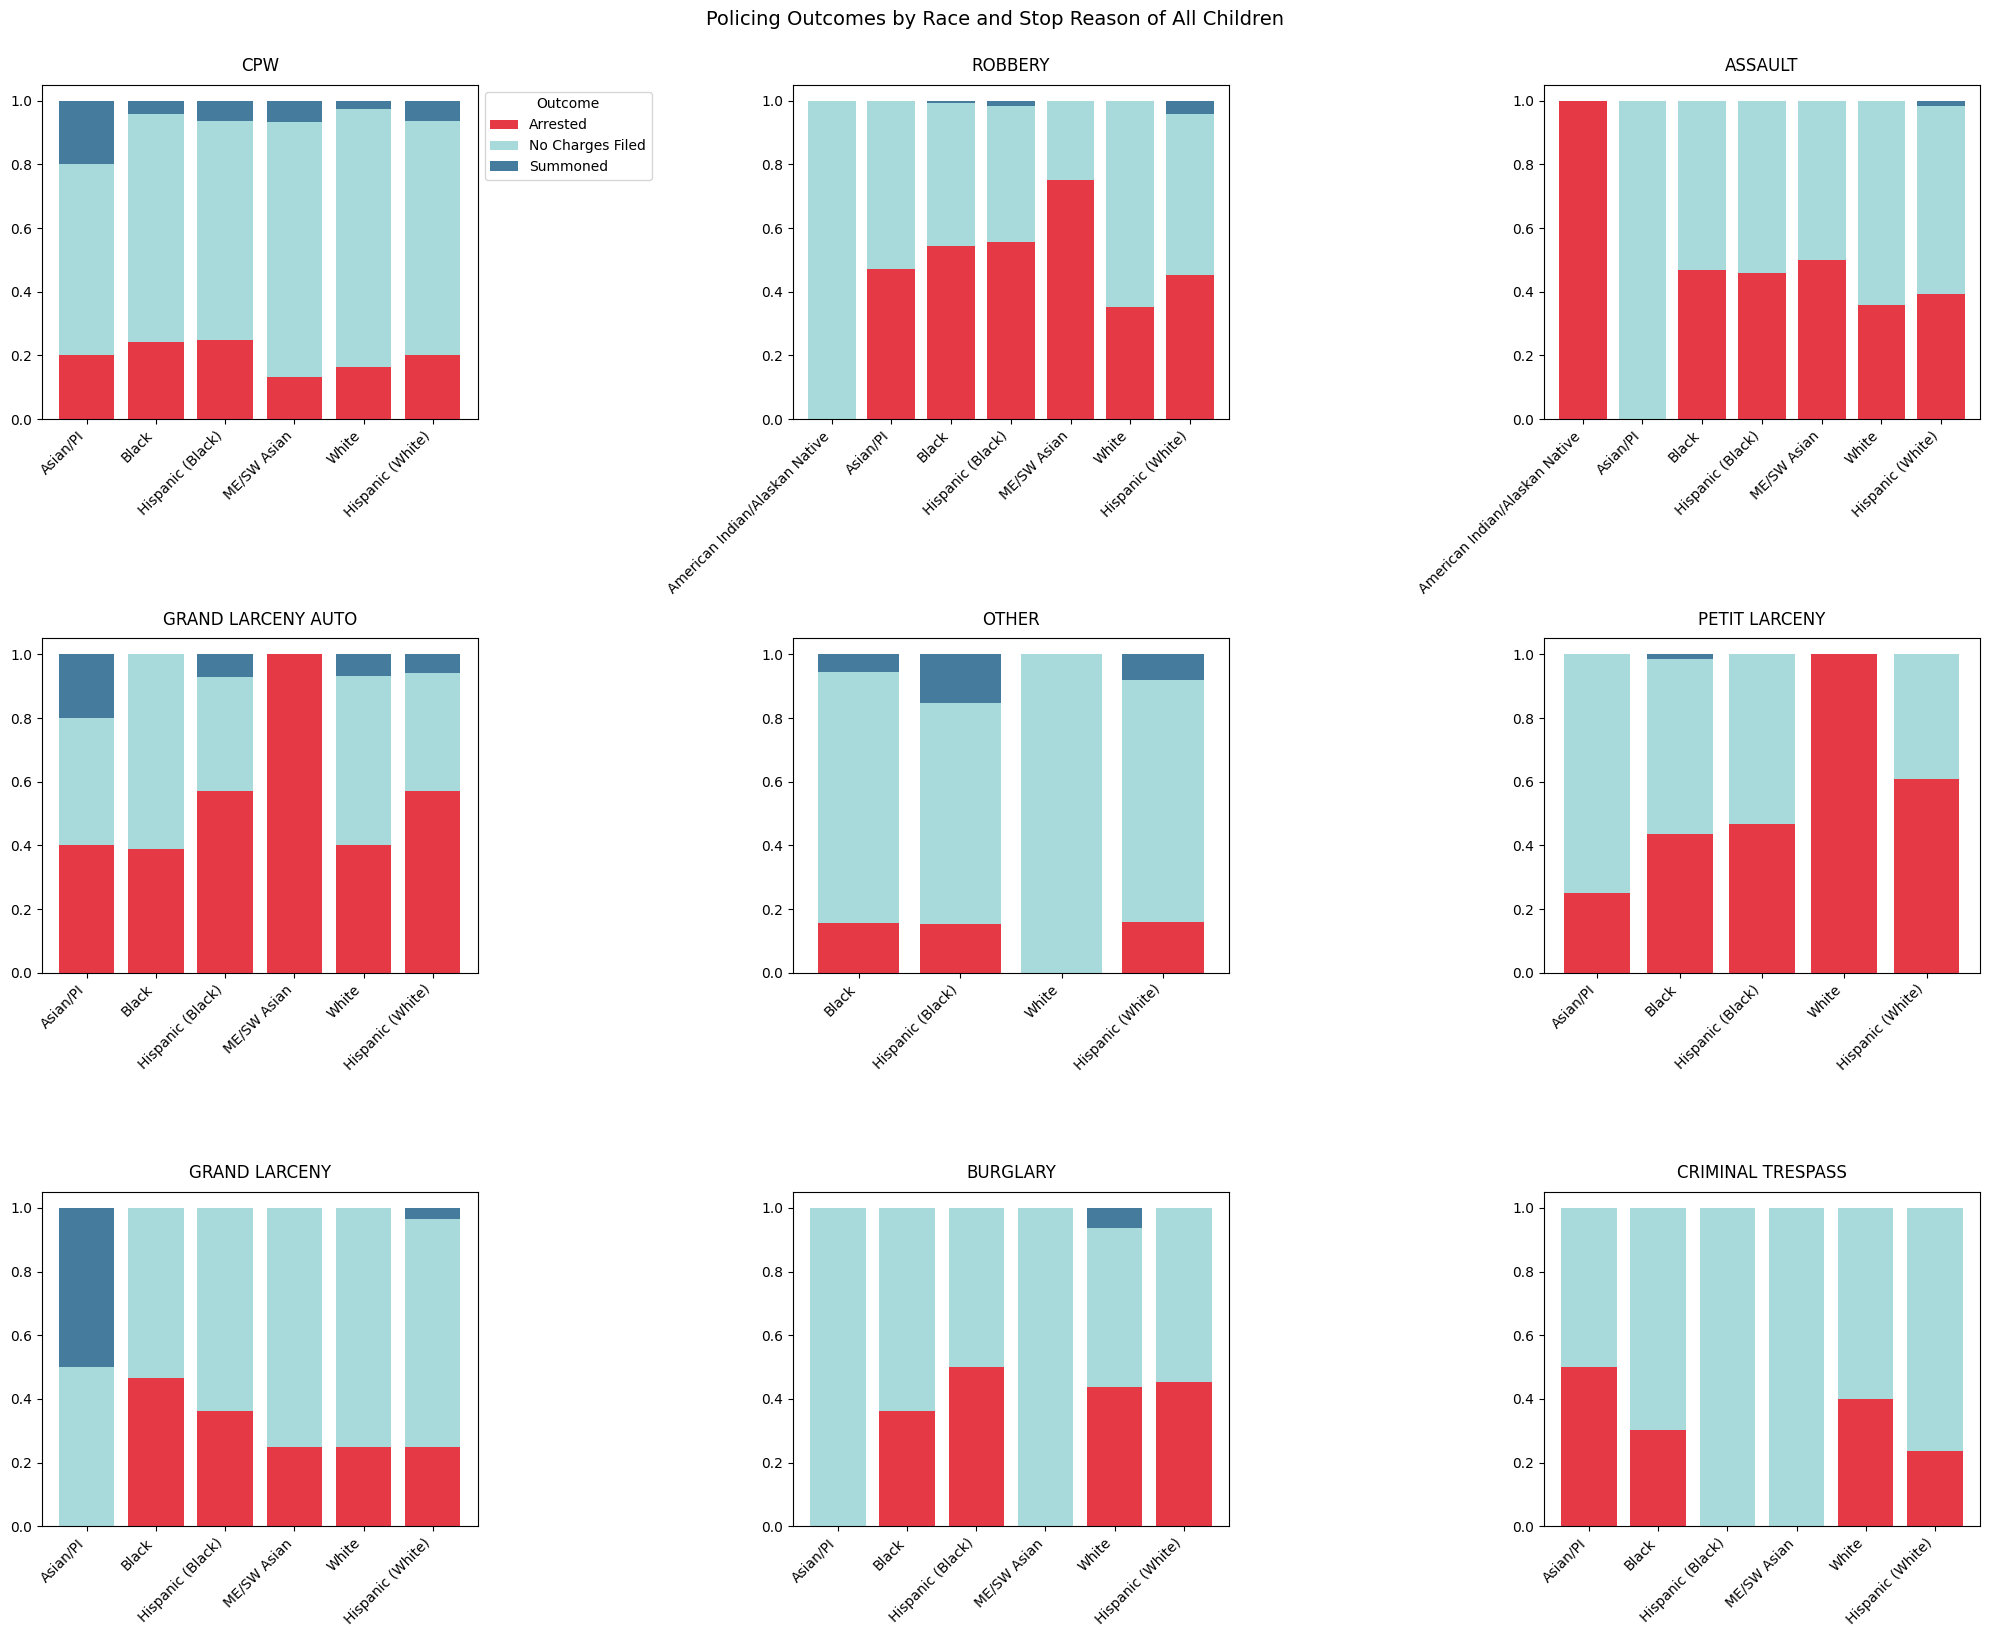

In [77]:
plot_stop_outcomes(all_children_df, n_reasons=9, figsize=(20,16), plot_title="Policing Outcomes by Race and Stop Reason of All Children")

In [78]:
# Feel free to take a look for yourself....
all_children_df

,SUSPECT_REPORTED_AGE,SUSPECT_RACE_DESCRIPTION,STOP_WAS_INITIATED,SUSPECTED_CRIME_DESCRIPTION,OFFICER_EXPLAINED_STOP_FLAG,OUTCOME_OF_STOP,FORCE_TYPE,STOP_LOCATION_BORO_NAME
2,17,WHITE HISPANIC,Based on Radio Run,GRAND LARCENY,True,No Charges Filed,No Force,BROOKLYN
3,13,WHITE HISPANIC,Based on Radio Run,GRAND LARCENY,True,No Charges Filed,No Force,BROOKLYN
4,14,WHITE HISPANIC,Based on Radio Run,GRAND LARCENY,True,No Charges Filed,No Force,BROOKLYN
5,17,WHITE HISPANIC,Based on Radio Run,GRAND LARCENY,True,No Charges Filed,No Force,BROOKLYN
11,17,WHITE,Based on Radio Run,BURGLARY,True,No Charges Filed,No Force,BROOKLYN
...,...,...,...,...,...,...,...,...
20205,17,BLACK HISPANIC,Based on Self Initiated,BURGLARY,True,No Charges Filed,No Force,BROOKLYN
20214,17,WHITE HISPANIC,Based on C/W on Scene,ASSAULT,True,No Charges Filed,No Force,BRONX
20216,14,BLACK,Based on Self Initiated,CPW,True,No Charges Filed,No Force,BRONX
20246,15,BLACK,Based on Radio Run,PETIT LARCENY,True,Arrested,No Force,BROOKLYN


### And it looks like an "early adulthood" for black and brown children
As we enter into the under 18 demographic, we begin to see the bifurcation of childhood based on race in that black and hispanic children are becoming targeted by the police themselves at nearly equal rates as being reported by someone in the child's community.  For black children, the number of stops from their pre-teen life to this teenage life is ~40x the amount of their earlier childhood.   

Moreover, for this age range, all children shot or tased are black and brown.  

## Where's the analysis for all NYers
I've got to get this notebook out the door so I'm omitting an analysis of stops for all New Yorkers here.  Instead, I'll refer the reader to [existing reports](#references) which were used to elucidate this notebook at large.

In [79]:
full_ny_demo_table = (
    final_df.groupby(['SUSPECT_REPORTED_AGE', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(full_ny_demo_table, "All 2024 Stops in NY")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
10,0.0,0.0,2.0,0.0,0.0,0.0,1.0,3.0
11,0.0,1.0,11.0,2.0,0.0,3.0,3.0,20.0
12,0.0,0.0,39.0,3.0,1.0,6.0,9.0,58.0
13,0.0,2.0,151.0,11.0,6.0,13.0,32.0,215.0
14,2.0,2.0,329.0,28.0,4.0,32.0,77.0,474.0
15,0.0,20.0,469.0,72.0,9.0,24.0,137.0,731.0
16,0.0,8.0,564.0,75.0,7.0,26.0,157.0,837.0


In [80]:
full_ny_demo_table = (
    final_df.groupby(['STOP_WAS_INITIATED', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
) 
show_demographic_table(full_ny_demo_table, "What was the suspected crime by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Based on C/W on Scene,4.0,57.0,"1,158.0",201.0,25.0,161.0,523.0,"2,129.0"
Based on Radio Run,18.0,231.0,"4,780.0",812.0,108.0,738.0,"1,890.0","8,577.0"
Based on Self Initiated,10.0,106.0,"6,269.0",958.0,67.0,315.0,"1,822.0","9,547.0"
TOTAL,32.0,394.0,"12,207.0","1,971.0",200.0,"1,214.0","4,235.0","20,253.0"
% OF TOTAL,0.2%,1.9%,60.3%,9.7%,1.0%,6.0%,20.9%,100.0%


In [81]:
full_ny_demo_table = (
    final_df.groupby(['SUSPECTED_CRIME_DESCRIPTION', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
) 
show_demographic_table(full_ny_demo_table, "What was the suspected crime by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
ASSAULT,7.0,47.0,876.0,155.0,26.0,113.0,435.0,"1,659.0"
AUTO STRIPPIG,0.0,0.0,7.0,6.0,1.0,4.0,13.0,31.0
AUTO STRIPPING,0.0,0.0,5.0,8.0,0.0,1.0,6.0,20.0
BURGLARY,5.0,39.0,471.0,126.0,17.0,160.0,284.0,"1,102.0"
CPSP,0.0,4.0,51.0,7.0,6.0,13.0,31.0,112.0
CPW,9.0,78.0,"6,859.0",952.0,70.0,280.0,"1,728.0","9,976.0"
CRIMINAL MISCHIEF,1.0,10.0,137.0,25.0,6.0,44.0,59.0,282.0
CRIMINAL POSSESSION OF CONTROLLED SUBSTANCE,0.0,2.0,44.0,7.0,1.0,20.0,39.0,113.0
CRIMINAL POSSESSION OF FORGED INSTRUMENT,0.0,0.0,6.0,0.0,1.0,0.0,2.0,9.0
CRIMINAL POSSESSION OF MARIHUANA,0.0,0.0,10.0,1.0,0.0,0.0,4.0,15.0


In [82]:
# Filtering out the no force values since they are the majority for all races, note that its ~1/5th of the cleaned df

full_ny_demo_table = (
    final_df[final_df['FORCE_TYPE'] != "No Force"].groupby(['FORCE_TYPE', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
) 

show_demographic_table(full_ny_demo_table, "What was the suspected crime by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Firearm Drawn,2.0,15.0,346.0,60.0,12.0,35.0,111.0,581.0
Handcuffs,5.0,69.0,"1,777.0",281.0,29.0,210.0,623.0,"2,994.0"
Other Physical Force,2.0,14.0,263.0,50.0,9.0,31.0,103.0,472.0
Pepper Spray,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
Restraint Used,0.0,4.0,346.0,39.0,1.0,13.0,90.0,493.0
Taser,1.0,0.0,62.0,11.0,1.0,6.0,22.0,103.0
Weapon Impact,0.0,0.0,6.0,0.0,0.0,0.0,2.0,8.0
TOTAL,10.0,102.0,"2,801.0",441.0,52.0,295.0,951.0,"4,652.0"
% OF TOTAL,0.2%,2.2%,60.2%,9.5%,1.1%,6.3%,20.4%,100.0%


In [83]:
# Filtering out the no force values since they are the majority for all races, note that its ~1/5th of the cleaned df

full_ny_demo_table = (
    final_df.groupby(['OUTCOME_OF_STOP', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
) 

show_demographic_table(full_ny_demo_table, "What was the suspected crime by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Arrested,8.0,159.0,"3,651.0",575.0,63.0,491.0,"1,338.0","6,285.0"
No Charges Filed,24.0,220.0,"8,091.0","1,326.0",132.0,696.0,"2,744.0","13,233.0"
Summoned,0.0,15.0,465.0,70.0,5.0,27.0,153.0,735.0
TOTAL,32.0,394.0,"12,207.0","1,971.0",200.0,"1,214.0","4,235.0","20,253.0"
% OF TOTAL,0.2%,1.9%,60.3%,9.7%,1.0%,6.0%,20.9%,100.0%


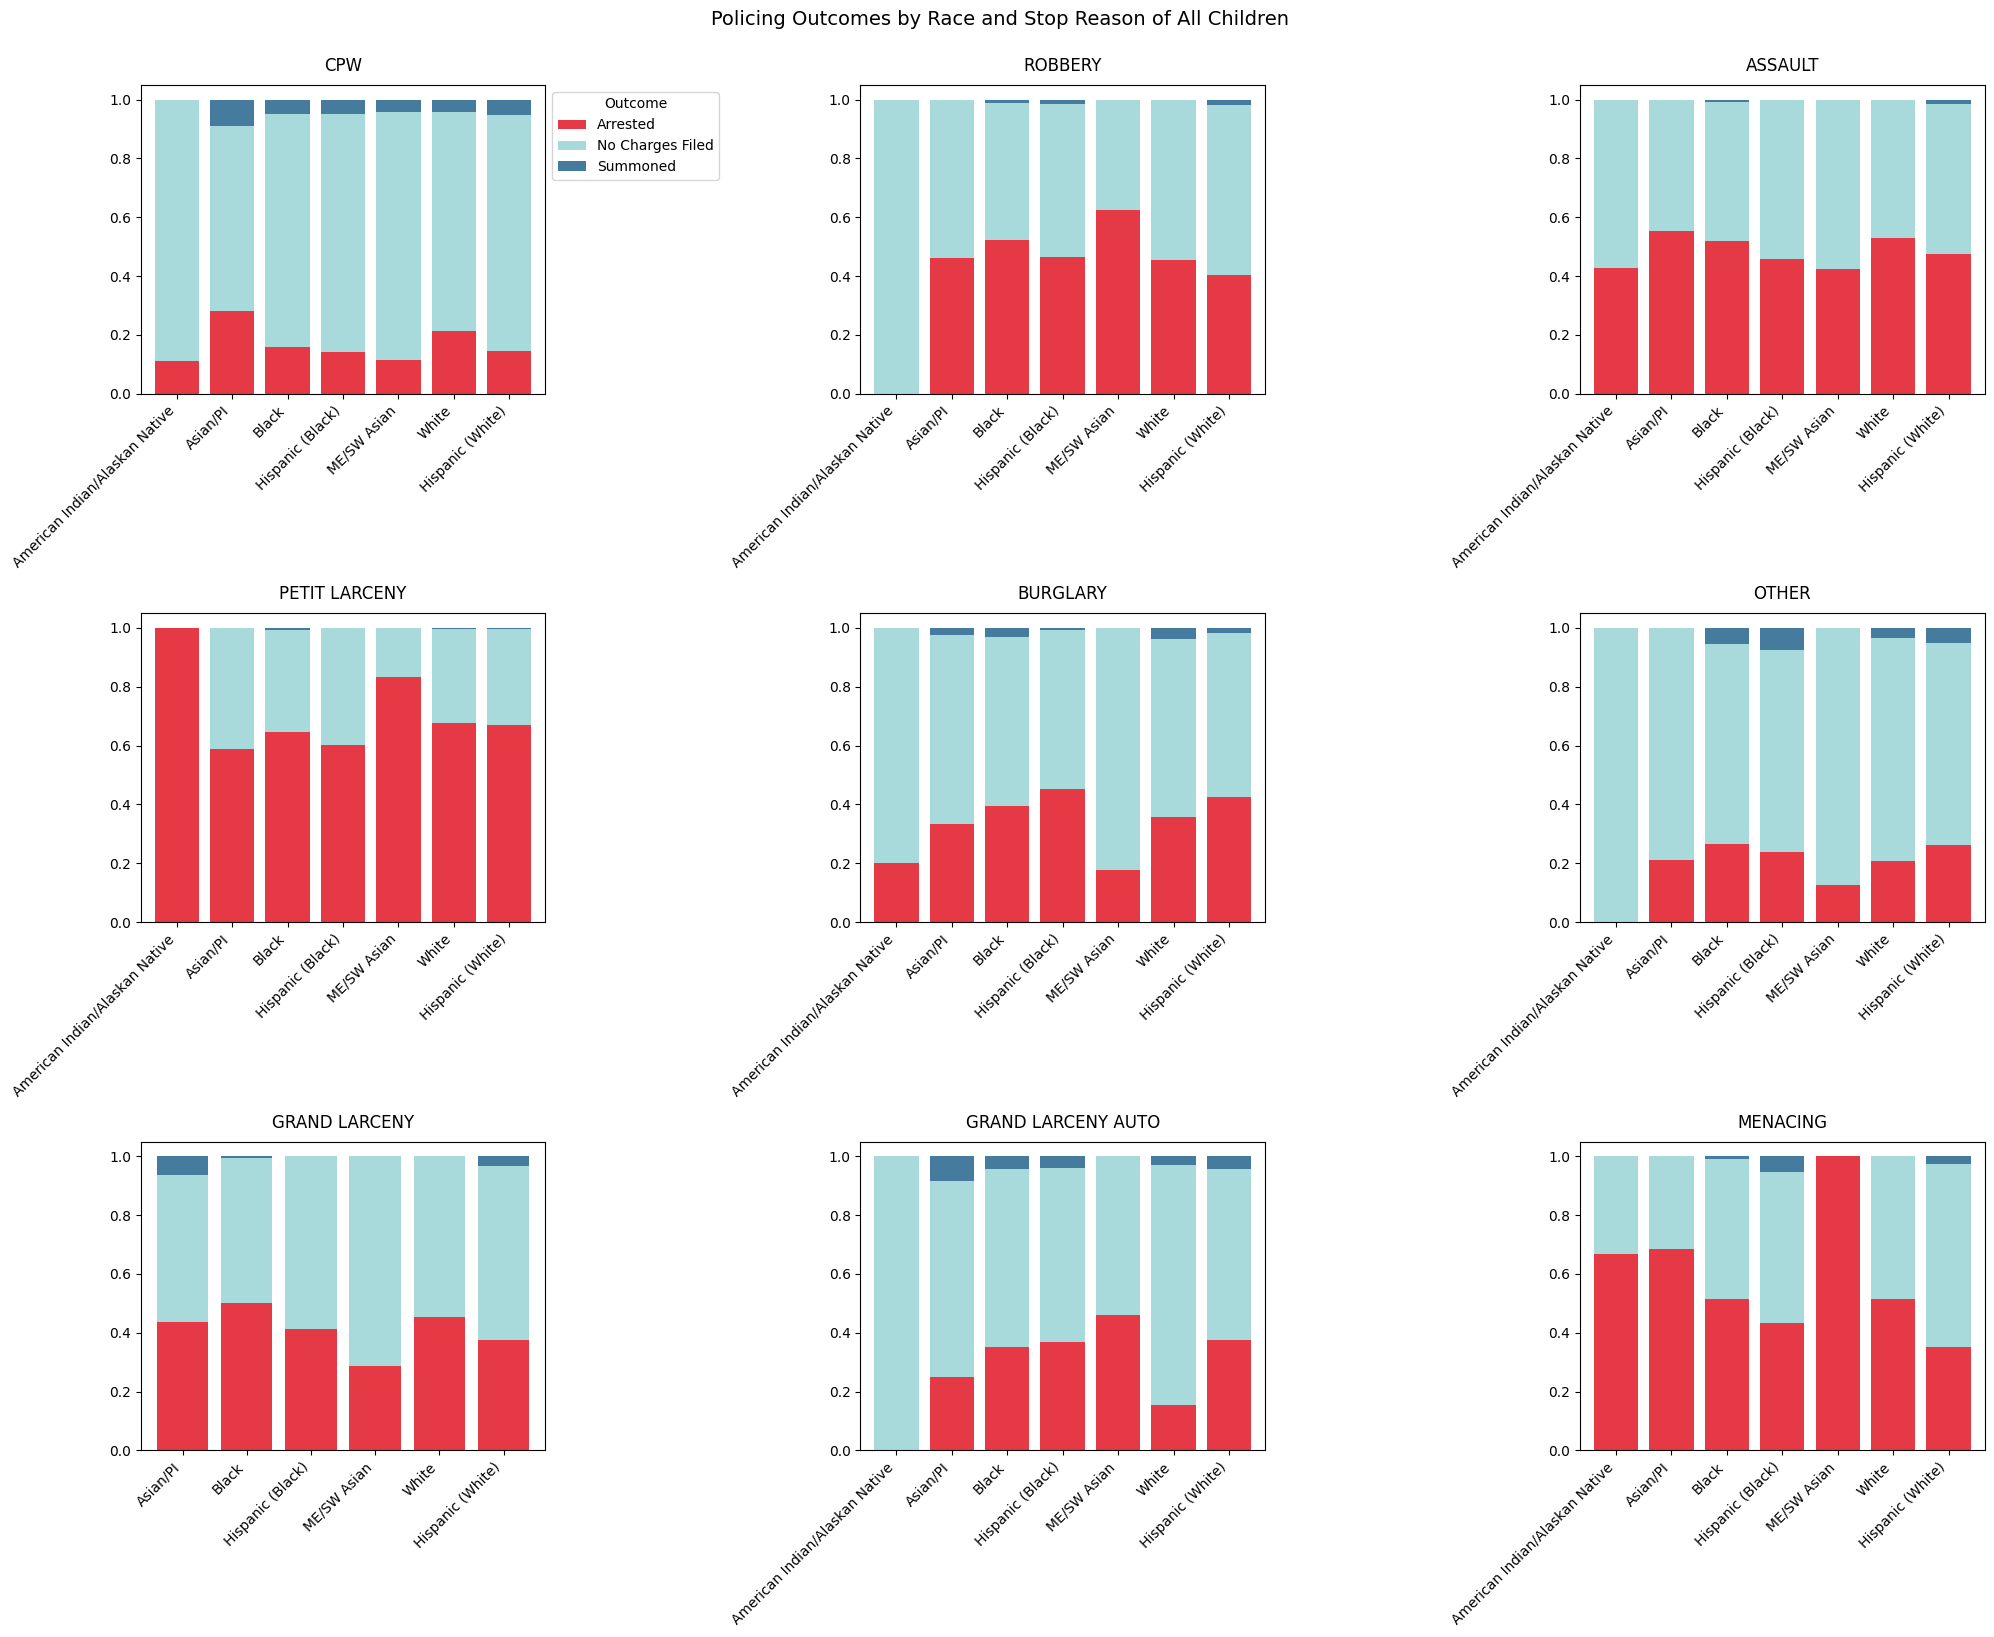

In [84]:
plot_stop_outcomes(final_df, n_reasons=9, figsize=(20,16), plot_title="Policing Outcomes by Race and Stop Reason of All Children")

## Initial Reflections
- Lots of banding at 18,20,30,40, etc.  seems like the police are rounding.  Given the common practice, I wonder how many children had their ages rounded up to make the stop seem more legitimate.
- And there's a lot of elderly people...
- Only black people were shot

In [85]:
elderly_df = final_df[final_df["SUSPECT_REPORTED_AGE"] > 65]
elderly_demo_table = (
    elderly_df.groupby(['STOP_WAS_INITIATED', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(elderly_demo_table, "What inititated the stop of the Elderly by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Based on C/W on Scene,0.0,1.0,14.0,1.0,1.0,7.0,6.0,30.0
Based on Radio Run,0.0,2.0,26.0,2.0,0.0,17.0,11.0,58.0
Based on Self Initiated,1.0,1.0,20.0,1.0,0.0,2.0,3.0,28.0
TOTAL,1.0,4.0,60.0,4.0,1.0,26.0,20.0,116.0
% OF TOTAL,0.9%,3.4%,51.7%,3.4%,0.9%,22.4%,17.2%,100.0%


In [86]:
elderly_demo_table = (
    elderly_df.groupby(['SUSPECTED_CRIME_DESCRIPTION', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
) 
show_demographic_table(elderly_demo_table, "What was the suspected crime of the Elderly by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
ASSAULT,0.0,1.0,8.0,0.0,0.0,4.0,4.0,17.0
BURGLARY,0.0,2.0,8.0,0.0,0.0,4.0,1.0,15.0
CPW,0.0,0.0,6.0,1.0,0.0,7.0,4.0,18.0
CRIMINAL MISCHIEF,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0
CRIMINAL POSSESSION OF CONTROLLED SUBSTANCE,0.0,0.0,4.0,0.0,0.0,0.0,1.0,5.0
CRIMINAL SALE OF CONTROLLED SUBSTANCE,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
CRIMINAL TRESPASS,0.0,0.0,4.0,0.0,1.0,1.0,0.0,6.0
FORCIBLE TOUCHING,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
GRAND LARCENY,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
GRAND LARCENY AUTO,0.0,0.0,1.0,0.0,0.0,3.0,0.0,4.0


In [87]:
elderly_demo_table = (
    elderly_df.groupby(['SUSPECTED_CRIME_DESCRIPTION', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
) 
show_demographic_table(elderly_demo_table, "What was the suspected crime of the Elderly by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
ASSAULT,0.0,1.0,8.0,0.0,0.0,4.0,4.0,17.0
BURGLARY,0.0,2.0,8.0,0.0,0.0,4.0,1.0,15.0
CPW,0.0,0.0,6.0,1.0,0.0,7.0,4.0,18.0
CRIMINAL MISCHIEF,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0
CRIMINAL POSSESSION OF CONTROLLED SUBSTANCE,0.0,0.0,4.0,0.0,0.0,0.0,1.0,5.0
CRIMINAL SALE OF CONTROLLED SUBSTANCE,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
CRIMINAL TRESPASS,0.0,0.0,4.0,0.0,1.0,1.0,0.0,6.0
FORCIBLE TOUCHING,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
GRAND LARCENY,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
GRAND LARCENY AUTO,0.0,0.0,1.0,0.0,0.0,3.0,0.0,4.0


In [88]:
elderly_demo_table = (
    elderly_df.groupby(['SUSPECTED_CRIME_DESCRIPTION', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
) 
show_demographic_table(elderly_demo_table, "What was the suspected crime of the Elderly by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
ASSAULT,0.0,1.0,8.0,0.0,0.0,4.0,4.0,17.0
BURGLARY,0.0,2.0,8.0,0.0,0.0,4.0,1.0,15.0
CPW,0.0,0.0,6.0,1.0,0.0,7.0,4.0,18.0
CRIMINAL MISCHIEF,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0
CRIMINAL POSSESSION OF CONTROLLED SUBSTANCE,0.0,0.0,4.0,0.0,0.0,0.0,1.0,5.0
CRIMINAL SALE OF CONTROLLED SUBSTANCE,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
CRIMINAL TRESPASS,0.0,0.0,4.0,0.0,1.0,1.0,0.0,6.0
FORCIBLE TOUCHING,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
GRAND LARCENY,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
GRAND LARCENY AUTO,0.0,0.0,1.0,0.0,0.0,3.0,0.0,4.0


In [89]:
elderly_demo_table = (
    elderly_df.groupby(['SUSPECTED_CRIME_DESCRIPTION', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
) 
show_demographic_table(elderly_demo_table, "What was the suspected crime of the Elderly by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
ASSAULT,0.0,1.0,8.0,0.0,0.0,4.0,4.0,17.0
BURGLARY,0.0,2.0,8.0,0.0,0.0,4.0,1.0,15.0
CPW,0.0,0.0,6.0,1.0,0.0,7.0,4.0,18.0
CRIMINAL MISCHIEF,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0
CRIMINAL POSSESSION OF CONTROLLED SUBSTANCE,0.0,0.0,4.0,0.0,0.0,0.0,1.0,5.0
CRIMINAL SALE OF CONTROLLED SUBSTANCE,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
CRIMINAL TRESPASS,0.0,0.0,4.0,0.0,1.0,1.0,0.0,6.0
FORCIBLE TOUCHING,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
GRAND LARCENY,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
GRAND LARCENY AUTO,0.0,0.0,1.0,0.0,0.0,3.0,0.0,4.0


In [90]:
elderly_demo_table = (
    elderly_df.groupby(['FORCE_TYPE', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
) 
show_demographic_table(elderly_demo_table, "What was the suspected crime of the Elderly by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Handcuffs,0.0,0.0,9.0,1.0,1.0,1.0,5.0,17.0
No Force,0.0,4.0,47.0,3.0,0.0,24.0,12.0,90.0
Other Physical Force,1.0,0.0,3.0,0.0,0.0,1.0,3.0,8.0
Restraint Used,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
TOTAL,1.0,4.0,60.0,4.0,1.0,26.0,20.0,116.0
% OF TOTAL,0.9%,3.4%,51.7%,3.4%,0.9%,22.4%,17.2%,100.0%


# Model Training (Why you're actually here)
While there's many ways to slice this cake, I am initially going to train and compare a multi-class Logistic Regression model with an Random Forest/Ensembling model.  Specifically, the models will be trained to predict the usage of force given various demographic, location, and other contextual features.


In [91]:
def prepare_model_features(df):
    model_df = df.copy()
    
    # ===== 1. Core Temporal Features =====
    model_df['HOUR_OF_DAY'] = model_df['STOP_FRISK_TIME']
    model_df['IS_NIGHT'] = model_df['HOUR_OF_DAY'].between(20, 6).astype(int)
    model_df['IS_WEEKEND'] = model_df['STOP_FRISK_DATE'].dt.dayofweek >= 5
    
    # ===== 2. Demographic Enhancements =====
    model_df['IS_CHILD'] = (model_df['SUSPECT_REPORTED_AGE'] < 18).astype(int)
    model_df['AGE_GROUP'] = pd.cut(
        model_df['SUSPECT_REPORTED_AGE'],
        bins=[0, 12, 18, 30, 50, 100],
        labels=['child', 'teen', 'young_adult', 'adult', 'senior']
    )
    
    # ===== 4. Location Intelligence =====
    # Borough-level force rates
    borough_force_rates = df.groupby('STOP_LOCATION_BORO_NAME')['OFFICER_USED_FORCE'].mean()
    model_df['BOROUGH_FORCE_RATE'] = model_df['STOP_LOCATION_BORO_NAME'].map(borough_force_rates)
    
    # ===== 5. Stop Context Features =====
    model_df['MULTIPLE_PERSONS_STOPPED'] = df['OTHER_PERSON_STOPPED_FLAG'].astype(int)
    
    # ===== 6. Officer Profile Features =====
    model_df['OFFICER_EXPERIENCE'] = np.where(
        df['ISSUING_OFFICER_RANK'].isin(['PO', 'PROBATIONARY POLICE OFFICER']),
        'junior',
        'senior'
    )
    
    # ===== 8. Smart Encoding =====
    # Categorical features with targeted encoding
    categorical_features = {
        'high_cardinality': [
            'SUSPECTED_CRIME_DESCRIPTION',
            'STOP_LOCATION_BORO_NAME',
            'NEIGHBORHOOD'
        ],
        'low_cardinality': [
            # 'SUSPECTED_CRIME_DESCRIPTION',
            # 'STOP_LOCATION_BORO_NAME',
            'SUSPECT_RACE_DESCRIPTION',
            'SUSPECT_SEX',
            'STOP_WAS_INITIATED',
            'OFFICER_EXPERIENCE',
            'AGE_GROUP'
        ]
    }
    
    # Target encoding for high-cardinality features
    for col in categorical_features['high_cardinality']:
        encoder = model_df.groupby(col)['OFFICER_USED_FORCE'].mean()
        model_df[f'{col}_ENCODED'] = model_df[col].map(encoder)
    
    # One-hot encode low-cardinality features
    encoded_df = pd.get_dummies(
        model_df[categorical_features['low_cardinality']],
        drop_first=True
    )
    
    # ===== 9. Final Feature Set =====
    numeric_features = [
        'SUSPECT_REPORTED_AGE',
        'SUSPECT_HEIGHT',
        'HOUR_OF_DAY',
        # 'NUM_FORCE_TYPES',
        'BOROUGH_FORCE_RATE'
    ]
    
    X = pd.concat([
        model_df[numeric_features],
        encoded_df,
        model_df[[
            'OFFICER_IN_UNIFORM_FLAG',
            'IS_NIGHT',
            'IS_WEEKEND',
            'IS_CHILD',
            # 'MULTIPLE_PERSONS_STOPPED'
        ]],
        model_df[[col for col in model_df.columns if '_ENCODED' in col]]
    ], axis=1)
    
    y = model_df['OFFICER_USED_FORCE']
    # y = model_df['OUTCOME_OF_STOP']
    
    # There might be a couple of null values left, clear them out assuming the delta isn't too high
    null_mask = X.isnull().any(axis=1)  # Boolean mask of rows with ANY nulls
    
    if null_mask.any():
        print(f"Dropping {null_mask.sum()} rows with null values")
        X_clean = X[~null_mask].copy()  # Keep only non-null rows
        y_clean = y[~null_mask].copy()
    else:
        X_clean, y_clean = X, y
    
    assert not X_clean.isnull().any().any(), "X still contains null values"
    assert len(X_clean) == len(y_clean), f"Length mismatch: X={len(X_clean)}, y={len(y_clean)}"
    
    return X_clean, y_clean

X, y = prepare_model_features(final_df)
assert not X.isnull().any().any(), "Null values remain in features"

In [92]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


print("Train distribution:", y_train.value_counts(normalize=True))
print("Test distribution:", y_test.value_counts(normalize=True))
X.head()

Train distribution: OFFICER_USED_FORCE
False    0.770275
True     0.229725
Name: proportion, dtype: float64
Test distribution: OFFICER_USED_FORCE
False    0.770427
True     0.229573
Name: proportion, dtype: float64


,SUSPECT_REPORTED_AGE,SUSPECT_HEIGHT,HOUR_OF_DAY,BOROUGH_FORCE_RATE,SUSPECT_RACE_DESCRIPTION_ASIAN / PACIFIC ISLANDER,SUSPECT_RACE_DESCRIPTION_BLACK,SUSPECT_RACE_DESCRIPTION_BLACK HISPANIC,SUSPECT_RACE_DESCRIPTION_MIDDLE EASTERN/SOUTHWEST ASIAN,SUSPECT_RACE_DESCRIPTION_WHITE,SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC,...,AGE_GROUP_young_adult,AGE_GROUP_adult,AGE_GROUP_senior,OFFICER_IN_UNIFORM_FLAG,IS_NIGHT,IS_WEEKEND,IS_CHILD,SUSPECTED_CRIME_DESCRIPTION_ENCODED,STOP_LOCATION_BORO_NAME_ENCODED,NEIGHBORHOOD_ENCODED
0,27,180,1,0.162764,False,False,False,False,False,True,...,True,False,False,True,0,False,0,0.154771,0.162764,0.116667
1,22,185,0,0.226136,False,True,False,False,False,False,...,True,False,False,True,0,False,0,0.154771,0.226136,0.170455
2,17,183,1,0.226136,False,False,False,False,False,True,...,False,False,False,True,0,False,1,0.282958,0.226136,0.214286
3,13,152,1,0.226136,False,False,False,False,False,True,...,False,False,False,True,0,False,1,0.282958,0.226136,0.214286
4,14,152,1,0.226136,False,False,False,False,False,True,...,False,False,False,True,0,False,1,0.282958,0.226136,0.214286


[[1987 1134]
 [ 352  578]]
              precision    recall  f1-score   support

       False       0.85      0.64      0.73      3121
        True       0.34      0.62      0.44       930

    accuracy                           0.63      4051
   macro avg       0.59      0.63      0.58      4051
weighted avg       0.73      0.63      0.66      4051



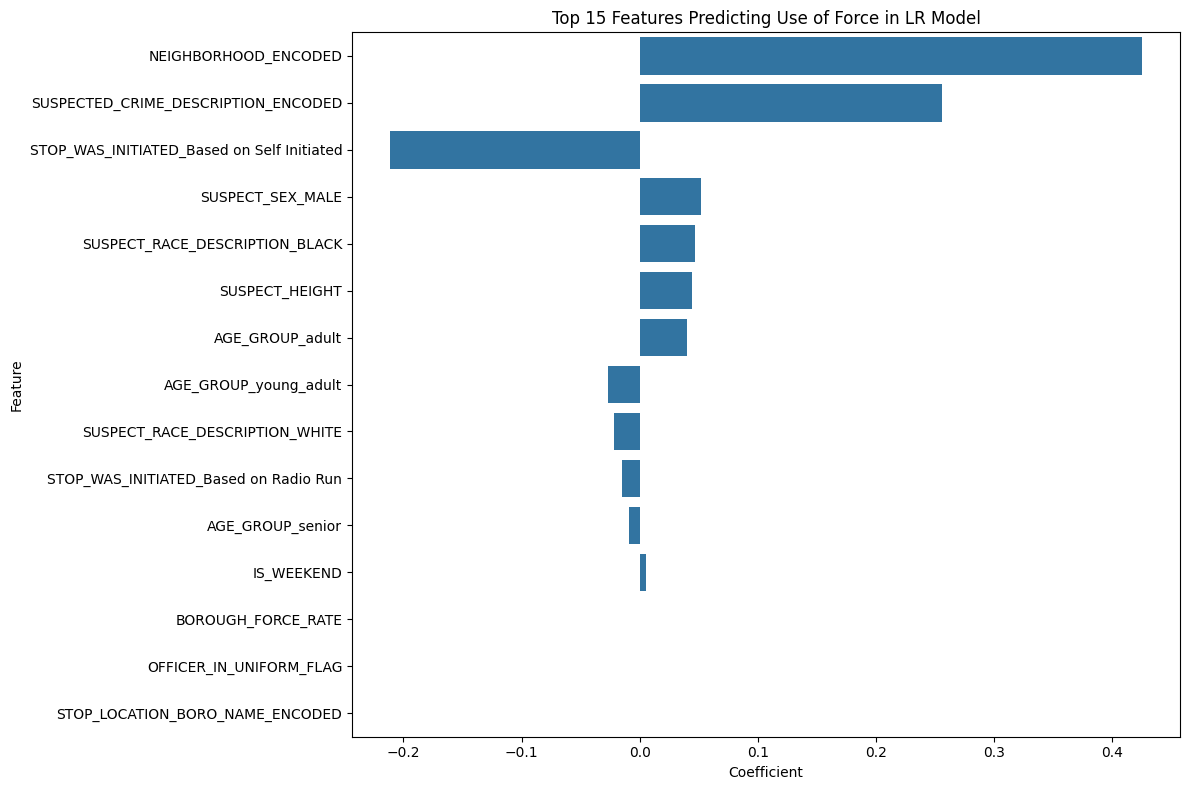

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Standardize features for quicker training...
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42, C= 0.01, penalty= 'l1', solver= 'liblinear')
lr_model.fit(X_train_scaled, y_train)

y_pred = lr_model.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Extract and visualize feature importances
def visualize_features(X, model, title='Top 15 Features Predicting Use of Force'):
    feature_names = X.columns
    coefficients = model.coef_[0]
    importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
    importance = importance.sort_values('Coefficient', key=abs, ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Coefficient', y='Feature', data=importance.head(15))
    plt.title(title)
    plt.tight_layout()
    plt.show()

visualize_features(X,lr_model, "Top 15 Features Predicting Use of Force in LR Model")
# [[2175 1494]
#  [ 156  234]]
#               precision    recall  f1-score   support

#        False       0.93      0.59      0.72      3669
#         True       0.14      0.60      0.22       390

#     accuracy                           0.59      4059
#    macro avg       0.53      0.60      0.47      4059
# weighted avg       0.86      0.59      0.68      4059

### First Pass LR
This naive LR model performs pretty poorly with 55% accuracy, though it has high precision for the majority class meaning that it reports few false positives and more accurately distinguishes the events without force.  But this model is largely useless given the overall poor performance, but especially given that we're concerned with training a model to accurately predict the use of force.

Best params: {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
Best recall: 0.6461474345096342
[[1916 1205]
 [ 330  600]]
              precision    recall  f1-score   support

       False       0.85      0.61      0.71      3121
        True       0.33      0.65      0.44       930

    accuracy                           0.62      4051
   macro avg       0.59      0.63      0.58      4051
weighted avg       0.73      0.62      0.65      4051



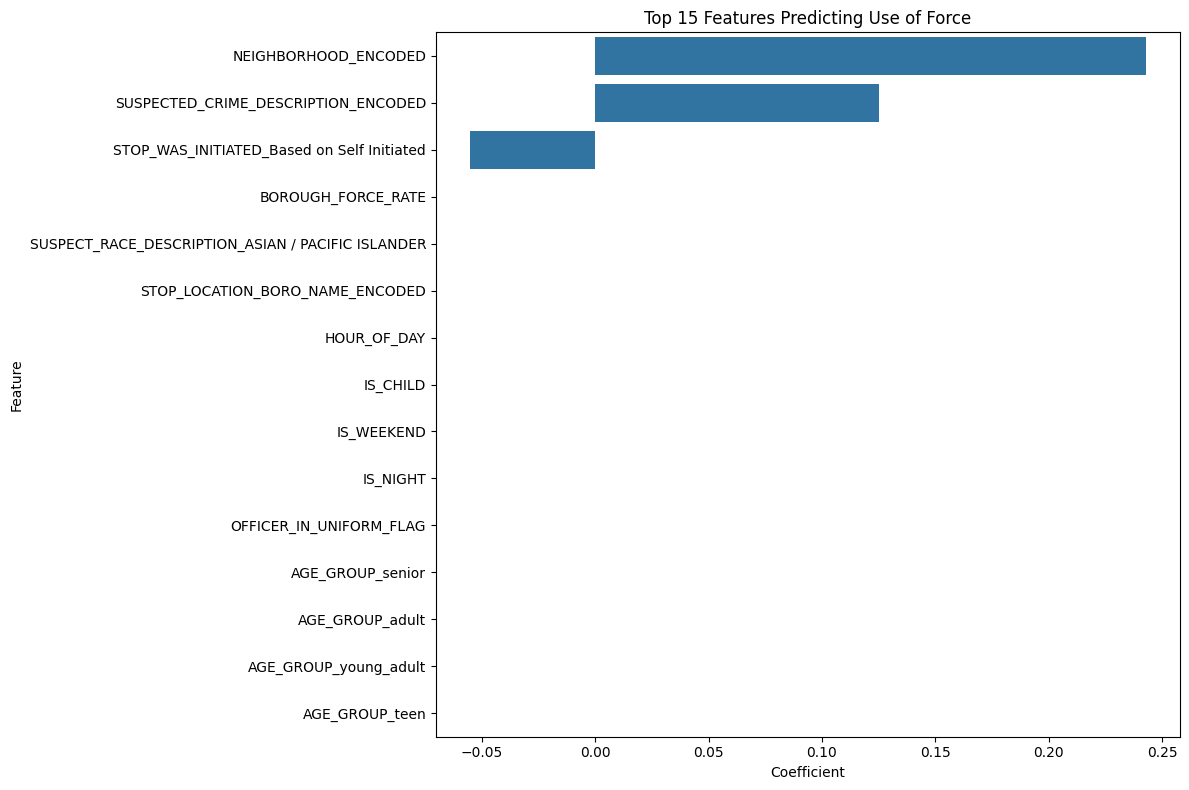

In [94]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Inverse regularization strength
    'penalty': ['l1', 'l2'],           # Regularization type
    'solver': ['liblinear', 'saga']     # Solvers that support L1
}

grid = GridSearchCV(
    LogisticRegression(class_weight='balanced', max_iter=1000),
    param_grid,
    cv=StratifiedKFold(n_splits=5),
    scoring='recall',  # Prioritize catching true positives
    n_jobs=-1
)
grid.fit(X_train_scaled, y_train)

print("Best params:", grid.best_params_)
print("Best recall:", grid.best_score_)

y_pred = grid.predict(X_test_scaled)

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
visualize_features(X,grid.best_estimator_)


## GridSearch + LR doesn't really improve things
The gridsearch augmented LR model still performs pretty poorly, though it achieved a higher recall score in training.  However, the model still performs poorly on the test dataset.  Mildly interesting, the features powering this gridsearched model are more highly skewed, suggesting some level of overfitting. 


In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    # class_weight={0: 1, 1: 10},  # 10x penalty for missing class 1
    random_state=42,
    class_weight="balanced"
)

rf_model.fit(X_train_scaled, y_train)
y_pred = rf_model.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Extract and visualize feature importances
# feature_names = X.columns
# coefficients = lr_model.coef_[0]
# importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
# importance = importance.sort_values('Coefficient', key=abs, ascending=False)

# plt.figure(figsize=(12, 8))
# sns.barplot(x='Coefficient', y='Feature', data=importance.head(15))
# plt.title('Top 15 Features Predicting Use of Force')
# plt.tight_layout()
# plt.show()
# [[3618   41]
#  [ 375   25]]
#               precision    recall  f1-score   support

#            0       0.91      0.99      0.95      3659
#            1       0.38      0.06      0.11       400

#     accuracy                           0.90      4059
#    macro avg       0.64      0.53      0.53      4059
# weighted avg       0.85      0.90      0.86      4059


[[3001  120]
 [ 757  173]]
              precision    recall  f1-score   support

       False       0.80      0.96      0.87      3121
        True       0.59      0.19      0.28       930

    accuracy                           0.78      4051
   macro avg       0.69      0.57      0.58      4051
weighted avg       0.75      0.78      0.74      4051



## Random Forest
Random Forest is better equipped to handle categorical data than a Logistic Regression model, but it seems to still overfit to the majority class despite overtly compensating for class imbalance via differential weighting.  It does perform markedly better on the majority class than the LR models though.

In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0)  # More aggressive weighting
gb_model.fit(X_train_scaled, y_train)
y_pred = gb_model.predict(X_test_scaled)

# Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[2908  213]
 [ 766  164]]
              precision    recall  f1-score   support

       False       0.79      0.93      0.86      3121
        True       0.44      0.18      0.25       930

    accuracy                           0.76      4051
   macro avg       0.61      0.55      0.55      4051
weighted avg       0.71      0.76      0.72      4051



## Beginning to go off script
Given the poor performance of the previous models, I began exploring models better suited to highly imbalanced datasets. This led me to more modern models including GradientBoost/XGBoost, LightGBM, and CatBoost which will be discussed further below.

In [97]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc

# Create LightGBM dataset
train_data = lgb.Dataset(X_train_scaled, label=y_train)
test_data = lgb.Dataset(X_test_scaled, label=y_test, reference=train_data)

# LightGBM params tuned for imbalance
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'aucpr',
    'is_unbalance': True,  # Automatically adjusts class weights
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1,
    'random_state': 42
}

# Train model
lgb_model = lgb.train(params, train_data, num_boost_round=200, valid_sets=[test_data])

# Predict
y_proba = lgb_model.predict(X_test_scaled)
y_pred = (y_proba >= 0.5).astype(int)

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Optional: PR-AUC
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print("LGBM PR AUC:", pr_auc)


[[2067 1054]
 [ 341  589]]
              precision    recall  f1-score   support

       False       0.86      0.66      0.75      3121
        True       0.36      0.63      0.46       930

    accuracy                           0.66      4051
   macro avg       0.61      0.65      0.60      4051
weighted avg       0.74      0.66      0.68      4051

LGBM PR AUC: 0.40674742187853474


In [105]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_recall_curve, auc
import numpy as np
from catboost import CatBoostClassifier

# Custom scorer for PR-AUC (since GridSearchCV doesn't natively support it)
def pr_auc_scorer(y_true, y_proba):
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    return auc(recall, precision)

# Define parameter grid
param_grid = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.05],
    'l2_leaf_reg': [1, 10, 50],
    'iterations': [500, 1000, 1500],
}

# Create CatBoost model (with early stopping)
cat_model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='F1',
    # scale_pos_weight=6,  # Adjust based on class imbalance
    verbose=0,
    random_seed=42,
    use_best_model=True,
)
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)  # (Negatives / Positives)
cat_model.set_params(scale_pos_weight=scale_pos_weight)
# Wrap in GridSearchCV
grid_search = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid,
    scoring=make_scorer(pr_auc_scorer, needs_proba=True),  # Optimize for PR-AUC
    cv=3,  # Fewer folds for speed
    n_jobs=-1,  # Parallelize
    verbose=1,  # Show progress
)

# Fit (with early stopping)
grid_search.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds=20,
)

# Best model
best_cat_model = grid_search.best_estimator_
y_proba = best_cat_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# [[1913 1208]
#  [ 303  627]]
#               precision    recall  f1-score   support

#        False       0.86      0.61      0.72      3121
#         True       0.34      0.67      0.45       930

#     accuracy                           0.63      4051
#    macro avg       0.60      0.64      0.59      4051
# weighted avg       0.74      0.63      0.66      4051

Fitting 3 folds for each of 81 candidates, totalling 243 fits


/home/yao/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


KeyboardInterrupt: 

In [99]:
from sklearn.metrics import precision_recall_curve

def get_tuned_results(model):
    # Get predicted probabilities
    y_proba = model.predict_proba(X_test)[:, 1]  

    # Find threshold that maximizes F1
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    best_threshold = thresholds[np.argmax(f1_scores)]

    # Predict with new threshold
    y_pred_tuned = (y_proba >= best_threshold).astype(int)
    print(classification_report(y_test, y_pred_tuned))
get_tuned_results(best_cat_model)
# precision    recall  f1-score   support

#        False       0.86      0.64      0.74      3121
#         True       0.35      0.65      0.46       930

#     accuracy                           0.64      4051
#    macro avg       0.61      0.65      0.60      4051
# weighted avg       0.74      0.64      0.67      4051

              precision    recall  f1-score   support

       False       0.85      0.69      0.76      3121
        True       0.37      0.61      0.46       930

    accuracy                           0.67      4051
   macro avg       0.61      0.65      0.61      4051
weighted avg       0.74      0.67      0.69      4051



## CatBoost FTW (at least for Recall)
So we finally have a model capable of predicting the model class with high recall, meaning that it predicts the minority class of police force usage with 97% accuracy.  Though this model is still largely useless overall given both its imprecision for the minority class (i.e. it also incorrect predicted many cases of without force used force at ~75%).  

For now, we'll proceed with analysing what the most salient/impactful features are for this model to make its predictions.

In [109]:
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Model specialized for recall
# cat_model = CatBoostClassifier(scale_pos_weight=10, random_state=42, verbose=0)
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    l2_leaf_reg=5,           # Increase regularization
    depth=5,
    loss_function='Logloss',
    eval_metric='AUC',
    scale_pos_weight=8,  # Balances positive class
    verbose=0,
    random_seed=42,
    # eval_metric='F1',        # Monitor F1 during training
    # use_best_model=True,     # Use best model by validation set
    # early_stopping_rounds=50,
    # verbose=100
)

# Model specialized for precision
# rf_model = RandomForestClassifier(class_weight={0:1, 1:1}, random_state=42)

# General performance model
# xgb_model = XGBClassifier(random_state=42)

# Meta-learner
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=20)

meta_model = LogisticRegression(class_weight='balanced', verbose=0)

stacked_model = StackingClassifier(
    estimators=[
        ('catboost', cat_model),
        ('random_forest', rf_model),
        ('lr', grid.best_estimator_)
    ],
    final_estimator=meta_model,
    cv=5,
    verbose=0
)


stacked_model.fit(X_train_scaled, y_train)

y_pred_proba = stacked_model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

# Evaluate performance
print("Ensemble Performance:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Ensemble Performance:
[[2042 1079]
 [ 304  626]]
              precision    recall  f1-score   support

       False       0.87      0.65      0.75      3121
        True       0.37      0.67      0.48       930

    accuracy                           0.66      4051
   macro avg       0.62      0.66      0.61      4051
weighted avg       0.75      0.66      0.68      4051



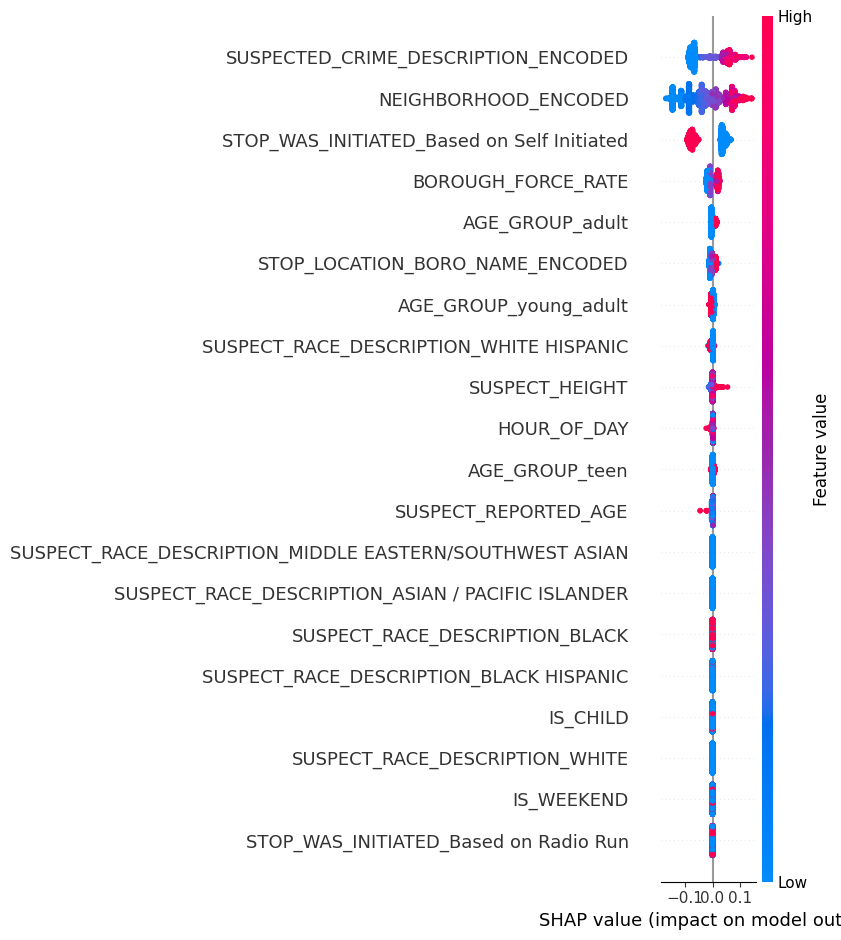

In [111]:
import shap
from catboost import Pool

# Prepare Pool object (CatBoost's data wrapper)
test_pool = Pool(data=X_test, label=y_test)
shap_values = cat_model.get_feature_importance(test_pool, type='ShapValues')

# Drop the last column (it's the expected value repeated for all rows)
shap_values = shap_values[:, :-1]

# Initialize SHAP explainer object (required for plotting)
explainer = shap.Explainer(cat_model)
shap.summary_plot(shap_values, X_test)


In [112]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances and names
feature_importances = cat_model.get_feature_importance()
feature_names = X_train.columns

# Sort features by importance (descending)
sorted_idx = np.argsort(feature_importances)[::-1]  # [::-1] reverses for descending
sorted_features = feature_names[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

print("Top Features:")
for feat, imp in zip(sorted_features, sorted_importances):
    print(f"{feat}: {imp:.4f}")

Top Features:
NEIGHBORHOOD_ENCODED: 35.1651
SUSPECTED_CRIME_DESCRIPTION_ENCODED: 31.7547
STOP_WAS_INITIATED_Based on Self Initiated: 20.4793
BOROUGH_FORCE_RATE: 3.2014
STOP_LOCATION_BORO_NAME_ENCODED: 2.6324
SUSPECT_HEIGHT: 1.8202
AGE_GROUP_adult: 1.3154
AGE_GROUP_teen: 1.1891
SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC: 0.8561
AGE_GROUP_young_adult: 0.5895
SUSPECT_REPORTED_AGE: 0.5009
HOUR_OF_DAY: 0.4958
SUSPECT_RACE_DESCRIPTION_MIDDLE EASTERN/SOUTHWEST ASIAN: 0.0000
SUSPECT_RACE_DESCRIPTION_ASIAN / PACIFIC ISLANDER: 0.0000
SUSPECT_RACE_DESCRIPTION_BLACK: 0.0000
SUSPECT_RACE_DESCRIPTION_BLACK HISPANIC: 0.0000
IS_CHILD: 0.0000
SUSPECT_RACE_DESCRIPTION_WHITE: 0.0000
IS_WEEKEND: 0.0000
STOP_WAS_INITIATED_Based on Radio Run: 0.0000
OFFICER_EXPERIENCE_senior: 0.0000
AGE_GROUP_senior: 0.0000
OFFICER_IN_UNIFORM_FLAG: 0.0000
IS_NIGHT: 0.0000
SUSPECT_SEX_MALE: 0.0000


In [113]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier

balanced_bag = BalancedBaggingClassifier(
    # base_estimator=DecisionTreeClassifier(),
    sampling_strategy='auto',
    replacement=False,
    random_state=42,
    n_estimators=50
)

balanced_bag.fit(X_train_scaled, y_train)
y_pred_proba = balanced_bag.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

# Evaluate performance
print("Ensemble Performance:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Ensemble Performance:
[[2307  814]
 [ 422  508]]
              precision    recall  f1-score   support

       False       0.85      0.74      0.79      3121
        True       0.38      0.55      0.45       930

    accuracy                           0.69      4051
   macro avg       0.61      0.64      0.62      4051
weighted avg       0.74      0.69      0.71      4051



In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.model_selection import cross_val_predict, StratifiedKFold

def create_balanced_ensemble(cat_model, rf_model, X_train, y_train, X_test, y_test):
    """
    Creates an ensemble that balances the high recall of CatBoost with the high precision of Random Forest
    
    Parameters:
    -----------
    cat_model : trained CatBoost model
    rf_model : trained Random Forest model
    X_train : training features
    y_train : training target
    X_test : test features
    y_test : test target
    
    Returns:
    --------
    Dictionary with results from different ensemble methods
    """
    results = {}
    
    # Get probabilities from both models
    cat_probs_train = cat_model.predict_proba(X_train)[:,1]
    rf_probs_train = rf_model.predict_proba(X_train)[:,1]
    
    cat_probs_test = cat_model.predict_proba(X_test)[:,1]
    rf_probs_test = rf_model.predict_proba(X_test)[:,1]
    
    # Method 1: Weighted average ensemble
    weights = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    best_f1 = 0
    best_weight = 0.5
    
    for cat_weight in weights:
        rf_weight = 1 - cat_weight
        ensemble_probs = cat_weight * cat_probs_train + rf_weight * rf_probs_train
        
        precision, recall, thresholds = precision_recall_curve(y_train, ensemble_probs)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        
        if len(thresholds) > 0:
            best_idx = np.argmax(f1_scores)
            if best_idx < len(thresholds):
                threshold = thresholds[best_idx]
                cur_f1 = f1_scores[best_idx]
                
                if cur_f1 > best_f1:
                    best_f1 = cur_f1
                    best_weight = cat_weight
                    best_threshold = threshold
    
    # Apply best weights and threshold to test data
    weighted_probs = best_weight * cat_probs_test + (1 - best_weight) * rf_probs_test
    weighted_preds = (weighted_probs >= best_threshold).astype(int)
    
    results['weighted'] = {
        'predictions': weighted_preds,
        'cat_weight': best_weight,
        'threshold': best_threshold,
        'report': classification_report(y_test, weighted_preds, output_dict=True),
        'confusion': confusion_matrix(y_test, weighted_preds),
        'probabilities': weighted_probs
    }
    
    # Method 2: Class-specific ensemble
    def optimize_threshold(y_true, y_probs):
        precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        
        if len(thresholds) > 0:
            best_idx = np.argmax(f1_scores)
            if best_idx < len(thresholds):
                return thresholds[best_idx]
        return 0.5
    
    # Find optimal thresholds for each model
    cat_threshold = optimize_threshold(y_train, cat_probs_train)
    rf_threshold = optimize_threshold(y_train, rf_probs_train)
    
    # Class-specific predictions
    class_specific = np.zeros_like(y_test)
    
    # Use CatBoost for positive class predictions (due to high recall)
    cat_positives = cat_probs_test >= cat_threshold
    class_specific[cat_positives] = 1
    
    # For the remaining instances, use RF's prediction for negative class
    remaining = ~cat_positives
    rf_negatives = rf_probs_test < rf_threshold
    class_specific[remaining & rf_negatives] = 0
    
    results['class_specific'] = {
        'predictions': class_specific,
        'cat_threshold': cat_threshold,
        'rf_threshold': rf_threshold,
        'report': classification_report(y_test, class_specific, output_dict=True),
        'confusion': confusion_matrix(y_test, class_specific)
    }
    
    # Method 3: Maximum probability ensemble (favors positive class)
    max_probs = np.maximum(cat_probs_test, rf_probs_test)
    max_threshold = optimize_threshold(y_train, np.maximum(cat_probs_train, rf_probs_train))
    max_preds = (max_probs >= max_threshold).astype(int)
    
    results['max_prob'] = {
        'predictions': max_preds,
        'threshold': max_threshold,
        'report': classification_report(y_test, max_preds, output_dict=True),
        'confusion': confusion_matrix(y_test, max_preds),
        'probabilities': max_probs
    }
    
    # Method 4: Cost-sensitive ensemble
    # Higher FN_COST means we penalize missing minority class more
    FN_COST = 10  # Cost of missing the minority class
    FP_COST = 1   # Cost of false positive
    
    # Expected cost of predicting negative
    cost_neg = FN_COST * cat_probs_test  # Trust CatBoost for positive class
    
    # Expected cost of predicting positive
    cost_pos = FP_COST * (1 - rf_probs_test)  # Trust RF for negative class
    
    # Choose prediction with minimum expected cost
    cost_preds = (cost_neg > cost_pos).astype(int)
    
    results['cost_sensitive'] = {
        'predictions': cost_preds,
        'report': classification_report(y_test, cost_preds, output_dict=True),
        'confusion': confusion_matrix(y_test, cost_preds)
    }
    
    # Method 5: Sequential combination
    # First use CatBoost to find potential positives with high recall
    potential_positives = cat_probs_test >= 0.3  # Lower threshold for higher recall
    
    # Then use RF to filter out false positives
    sequential_preds = np.zeros_like(y_test)
    sequential_preds[potential_positives & (rf_probs_test >= 0.1)] = 1
    
    results['sequential'] = {
        'predictions': sequential_preds,
        'report': classification_report(y_test, sequential_preds, output_dict=True),
        'confusion': confusion_matrix(y_test, sequential_preds)
    }
    
    return results

def visualize_ensemble_results(results, y_test):
    """
    Visualize performance of different ensemble methods
    """
    methods = list(results.keys())
    precision = [results[m]['report']['1']['precision'] for m in methods]
    recall = [results[m]['report']['1']['recall'] for m in methods]
    f1 = [results[m]['report']['1']['f1-score'] for m in methods]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(methods))
    width = 0.25
    
    ax.bar(x - width, precision, width, label='Precision', color='#3498db')
    ax.bar(x, recall, width, label='Recall', color='#e74c3c')
    ax.bar(x + width, f1, width, label='F1-Score', color='#2ecc71')
    
    ax.set_xticks(x)
    ax.set_xticklabels(methods)
    ax.set_ylabel('Score')
    ax.set_title('Ensemble Methods Performance on Minority Class')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Plot PR curve for methods with probability outputs
    plt.figure(figsize=(10, 8))
    
    for method in ['weighted', 'max_prob']:
        if 'probabilities' in results[method]:
            precision, recall, _ = precision_recall_curve(y_test, results[method]['probabilities'])
            plt.plot(recall, precision, lw=2, label=f'{method} (AUC={auc(recall, precision):.3f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for Ensemble Methods')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    
    return

# Example usage:
ensemble_results = create_balanced_ensemble(cat_model, rf_model, X_train_scaled, y_train, X_test_scaled, y_test)
# visualize_ensemble_results(ensemble_results, y_test)

# Print detailed results for a specific method
def print_ensemble_results(results, method_name):
    if method_name in results:
        method = results[method_name]
        print(f"===== {method_name.upper()} ENSEMBLE RESULTS =====")
        print("Confusion Matrix:")
        print(method['confusion'])
        print("\nClassification Report:")
        for class_label, metrics in method['report'].items():
            if isinstance(metrics, dict):
                print(f"Class {class_label}:")
                for metric_name, value in metrics.items():
                    print(f"  {metric_name}: {value:.4f}")
        
        # Print any method-specific parameters
        for param_name, param_value in method.items():
            if param_name not in ['predictions', 'report', 'confusion', 'probabilities']:
                print(f"{param_name}: {param_value}")
        print("\n")
    else:
        print(f"Method {method_name} not found in results")

print_ensemble_results(ensemble_results, 'weighted')

===== WEIGHTED ENSEMBLE RESULTS =====
Confusion Matrix:
[[2954  167]
 [ 704  226]]

Classification Report:
Class False:
  precision: 0.8075
  recall: 0.9465
  f1-score: 0.8715
  support: 3121.0000
Class True:
  precision: 0.5751
  recall: 0.2430
  f1-score: 0.3416
  support: 930.0000
Class macro avg:
  precision: 0.6913
  recall: 0.5948
  f1-score: 0.6066
  support: 4051.0000
Class weighted avg:
  precision: 0.7542
  recall: 0.7850
  f1-score: 0.7499
  support: 4051.0000
cat_weight: 0.3
threshold: 0.4998174093659704




/home/yao/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/yao/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/yao/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Ensemble Performance:
[[3079   42]
 [ 864   66]]
              precision    recall  f1-score   support

       False       0.78      0.99      0.87      3121
        True       0.61      0.07      0.13       930

    accuracy                           0.78      4051
   macro avg       0.70      0.53      0.50      4051
weighted avg       0.74      0.78      0.70      4051



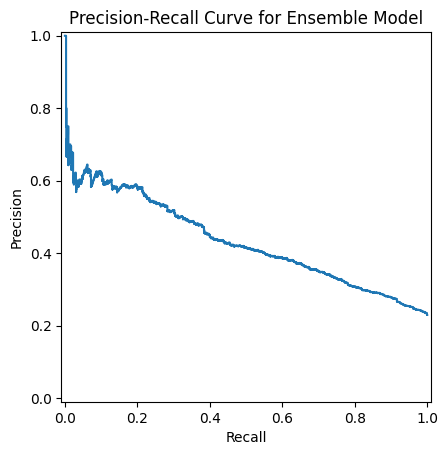

In [115]:
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV

# Initialize the base models
# catboost = CatBoostClassifier(
#     iterations=500,
#     learning_rate=0.05,
#     depth=6,
#     loss_function='Logloss',
#     eval_metric='AUC',
#     scale_pos_weight=10,
#     verbose=0,
#     random_seed=42
# )

# rf = RandomForestClassifier(
#     n_estimators=200,
#     max_depth=10,
#     min_samples_split=5,
#     class_weight="balanced",
#     random_state=42
# )

# Create calibrated versions to improve probability estimates
calibrated_cat = CalibratedClassifierCV(cat_model, method='isotonic', cv=3)
calibrated_rf = CalibratedClassifierCV(rf_model, method='isotonic', cv=3)

# Create the ensemble
ensemble = VotingClassifier(
    estimators=[
        ('catboost', calibrated_cat),
        ('random_forest', calibrated_rf)
    ],
    voting='soft',  # Use weighted probability voting
    weights=[2, 1]  # Give CatBoost more weight due to better recall
)

# Train the ensemble
ensemble.fit(X_train_scaled, y_train)

# Make predictions
y_pred_proba = ensemble.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

# Evaluate performance
print("Ensemble Performance:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot precision-recall curve
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title('Precision-Recall Curve for Ensemble Model')
plt.show()

In [116]:
from sklearn.metrics import fbeta_score

# Find optimal threshold for F2-score (emphasizing recall)
thresholds = np.linspace(0.1, 0.5, 50)
f2_scores = [fbeta_score(y_test, (y_pred_proba >= t).astype(int), beta=2) 
             for t in thresholds]

optimal_threshold = thresholds[np.argmax(f2_scores)]
print(f"Optimal threshold: {optimal_threshold:.3f}")

# Evaluate with optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
print("\nPerformance with Optimal Threshold:")
print(confusion_matrix(y_test, y_pred_optimal))
print(classification_report(y_test, y_pred_optimal))

Optimal threshold: 0.133

Performance with Optimal Threshold:
[[ 897 2224]
 [  84  846]]
              precision    recall  f1-score   support

       False       0.91      0.29      0.44      3121
        True       0.28      0.91      0.42       930

    accuracy                           0.43      4051
   macro avg       0.59      0.60      0.43      4051
weighted avg       0.77      0.43      0.43      4051



In [ ]:
from sklearn.metrics import confusion_matrix

# Define our cost matrix (FN cost 10x FP cost)
cost_matrix = np.array([
    [0, 1],   # True Negative, False Positive costs
    [10, 0]   # False Negative, True Positive costs
])

# Create a proper scorer function
def cost_scorer(estimator, X, y_true):
    y_pred = estimator.predict(X).astype(int)  # Ensure predictions are int
    cm = confusion_matrix(y_true, y_pred)
    
    # Explicitly convert to float before multiplication
    cm = cm.astype(float)
    total_cost = np.sum(cm * cost_matrix)
    
    return -float(total_cost)  # Ensure result is a float

# Now create GridSearchCV with correct parameters
param_grid = {
    'catboost__estimator__scale_pos_weight': [5, 10, 20],
    'random_forest__estimator__class_weight': ['balanced', {0:1, 1:10}]
}

grid = GridSearchCV(
    ensemble,
    param_grid,
    scoring=cost_scorer,
    cv=5,
    n_jobs=-1,
    refit=True  # Refit best estimator on full training data
)

# Fit the grid search
grid.fit(X_train_scaled, y_train)

# Get best estimator
best_ensemble = grid.best_estimator_

# Evaluate
y_pred_cost = best_ensemble.predict_proba(X_test_scaled)[:, 1] > optimal_threshold
print(classification_report(y_test, y_pred_cost))


In [ ]:

# Find threshold that achieves at least 80% recall with maximum precision
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
valid_indices = np.where(recalls[:-1] >= 0.8)[0]  # Exclude the last recall value

if len(valid_indices) == 0:
    print("No thresholds achieve 80% recall")
else:
    # Get corresponding values
    viable_thresholds = thresholds[valid_indices]
    viable_precisions = precisions[valid_indices]  # Use the same indices for precisions
    
    # Select threshold with maximum precision among viable options
    optimal_idx = np.argmax(viable_precisions)
    new_threshold = viable_thresholds[optimal_idx]
    
    print(f"New threshold: {new_threshold:.3f}")
    print(f"Precision: {viable_precisions[optimal_idx]:.2f}")
    print(f"Recall: {recalls[valid_indices][optimal_idx]:.2f}")
    
    # Re-evaluate
    y_pred_new = (y_pred_proba >= new_threshold).astype(int)
    print(classification_report(y_test, y_pred_new))

New threshold: 0.187
Precision: 0.28
Recall: 0.81
              precision    recall  f1-score   support

       False       0.87      0.38      0.53      3121
        True       0.28      0.81      0.41       930

    accuracy                           0.48      4051
   macro avg       0.57      0.59      0.47      4051
weighted avg       0.73      0.48      0.50      4051



In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from catboost import CatBoostClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np
import matplotlib.pyplot as plt

# 1. Train base models with appropriate class weighting
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight={0:1, 1:10},  # Match your cost matrix
    max_depth=10,  # Prevent overfitting
    random_state=42
)

cb = CatBoostClassifier(
    iterations=500,
    scale_pos_weight=10,  # Match your cost matrix
    depth=6,  # Prevent overfitting
    random_seed=42,
    verbose=0
)

# 2. Calibrate the probabilities
rf_calib = CalibratedClassifierCV(rf, method='isotonic', cv=5)
cb_calib = CalibratedClassifierCV(cb, method='isotonic', cv=5)

# 3. Create a soft voting ensemble with calibrated models
ensemble = VotingClassifier(
    estimators=[
        ('rf', rf_calib),
        ('cb', cb_calib)
    ],
    voting='soft'  # Use probability outputs
)

# 4. Fit the ensemble
ensemble.fit(X_train_scaled, y_train)

# 5. Find optimal threshold based on F-beta score (beta > 1 for recall emphasis)
y_proba = ensemble.predict_proba(X_test_scaled)[:, 1]  # Validation set probabilities
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Calculate F-2 score (emphasizes recall more)
beta = 2
f2_scores = ((1 + beta**2) * precision * recall) / ((beta**2 * precision) + recall + 1e-10)
optimal_idx = np.argmax(f2_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.3f}")

# 6. Final evaluation with optimal threshold
y_pred_final = (ensemble.predict_proba(X_test_scaled)[:, 1] >= optimal_threshold).astype(int)
print(classification_report(y_test, y_pred_final))

Optimal threshold: 0.137


In [ ]:
print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

       False       0.91      0.19      0.32      3121
        True       0.26      0.94      0.40       930

    accuracy                           0.36      4051
   macro avg       0.59      0.57      0.36      4051
weighted avg       0.76      0.36      0.34      4051



0:	learn: 0.6876721	test: 0.4253726	best: 0.4253726 (0)	total: 10.7ms	remaining: 10.7s
100:	learn: 0.6992139	test: 0.4353762	best: 0.4356569 (97)	total: 852ms	remaining: 7.58s
200:	learn: 0.7103197	test: 0.4464272	best: 0.4464272 (200)	total: 1.46s	remaining: 5.8s
300:	learn: 0.7179209	test: 0.4558418	best: 0.4558418 (300)	total: 2.08s	remaining: 4.84s
400:	learn: 0.7263260	test: 0.4660813	best: 0.4660813 (400)	total: 2.73s	remaining: 4.09s
500:	learn: 0.7351457	test: 0.4776355	best: 0.4776355 (500)	total: 3.37s	remaining: 3.35s
600:	learn: 0.7452249	test: 0.4904812	best: 0.4904812 (598)	total: 3.96s	remaining: 2.63s
700:	learn: 0.7528606	test: 0.5004881	best: 0.5004881 (700)	total: 4.53s	remaining: 1.93s
800:	learn: 0.7575850	test: 0.5068066	best: 0.5069706 (794)	total: 5.09s	remaining: 1.26s
900:	learn: 0.7624896	test: 0.5135247	best: 0.5135247 (900)	total: 5.69s	remaining: 625ms
999:	learn: 0.7657213	test: 0.5192742	best: 0.5192742 (999)	total: 6.31s	remaining: 0us

bestTest = 0.519

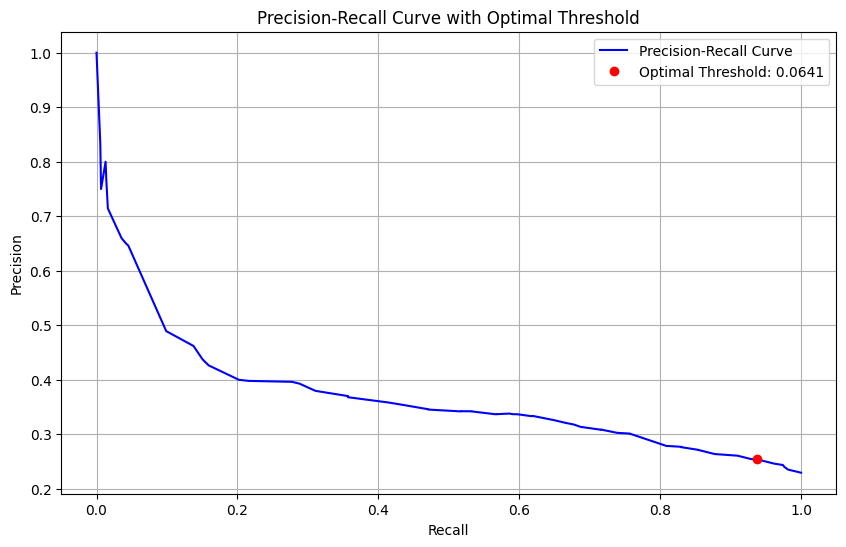

Confusion Matrix:
[[ 562 2559]
 [  58  872]]
Total Cost: 2791

Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.18      0.30      3121
        True       0.25      0.94      0.40       930

    accuracy                           0.35      4051
   macro avg       0.58      0.56      0.35      4051
weighted avg       0.76      0.35      0.32      4051


Classification Report with Default Threshold (0.5):
              precision    recall  f1-score   support

       False       0.79      0.94      0.86      3121
        True       0.43      0.16      0.23       930

    accuracy                           0.76      4051
   macro avg       0.61      0.55      0.54      4051
weighted avg       0.71      0.76      0.71      4051



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import precision_recall_curve, f1_score, classification_report, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split

# Step 1: Prepare the data with proper weights
# Create sample weights based on your cost matrix
sample_weights = np.ones(len(y_train))
sample_weights[y_train == 1] = 4  # FN costs 10x FP

# Step 2: Create training pool with sample weights
train_pool = Pool(
    data=X_train_scaled,
    label=y_train,
    weight=sample_weights
)

# Step 3: Configure and train CatBoost with careful parameters to avoid overfitting
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,                 # Limit depth to prevent overfitting
    l2_leaf_reg=5,           # Increase regularization
    random_seed=42,
    loss_function='Logloss', # Binary classification
    eval_metric='F1',        # Monitor F1 during training
    use_best_model=True,     # Use best model by validation set
    early_stopping_rounds=50,
    verbose=100
)

# Create validation pool for early stopping
val_pool = Pool(X_train_scaled, y_train)

# Train the model
catboost_model.fit(
    train_pool,
    eval_set=val_pool,
    plot=False
)

# Step 4: Calibrate the model probabilities
calibrated_model = CalibratedClassifierCV(
    catboost_model,
    method='isotonic',  # Non-parametric approach to calibration
    cv='prefit'         # Model is already trained
)
calibrated_model.fit(X_train_scaled, y_train)

# Step 5: Find optimal threshold that balances your needs
# Predict probabilities on validation set
y_proba = calibrated_model.predict_proba(X_test_scaled)[:, 1]

# Create a range of thresholds to evaluate
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Calculate F-beta scores (beta=2 gives more weight to recall)
beta = 2
f_beta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall + 1e-10)

# Find optimal threshold by F-beta
optimal_idx = np.argmax(f_beta)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"At this threshold - Precision: {precision[optimal_idx]:.4f}, Recall: {recall[optimal_idx]:.4f}")

# Step 6: Visualize precision-recall tradeoff
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, 'b-', label='Precision-Recall Curve')
plt.plot(recall[optimal_idx], precision[optimal_idx], 'ro', label=f'Optimal Threshold: {optimal_threshold:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Optimal Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Step 7: Evaluate on test set using optimal threshold
y_proba_test = calibrated_model.predict_proba(X_test_scaled)[:, 1]
y_pred_test = (y_proba_test >= optimal_threshold).astype(int)

# Calculate confusion matrix with costs
cm = confusion_matrix(y_test, y_pred_test)
cost = (cm[0, 1] * 1) + (cm[1, 0] * 4)  # FP cost * 1 + FN cost * 10

print("Confusion Matrix:")
print(cm)
print(f"Total Cost: {cost}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

# Step 8: Compare with default threshold (0.5)
y_pred_default = (y_proba_test >= 0.5).astype(int)
print("\nClassification Report with Default Threshold (0.5):")
print(classification_report(y_test, y_pred_default))

# Model Analysis and Reflections
I initially approached this project with the intention of modelling uses of force without arrest or summons, but there just wasn't enough data/statistical power to get strong results given the 10:1 majority : minority class ratio.  As such, I revised the target variable to a more broad and more representative value of whether the officer used physical force during the stop.

With a 3:1 class balance, this target yielded much better results, though still weak when evaluating overall performance. Logistic Regression models are useful in categorization tasks, while Random Forest classifiers work best on highly categorical data like we have here.  These models generally overfit the majority class however, despite various methods from simple class balancing and differential weighting, stratifying the data, synthetic balancing with SMOTE, etc.  This resulted in a series of models which had little ability to properly predict what I'm actually trying to determine, which is what are the factors which lead to use of force in a given stop.

So I went back to the toolshed to test classifiers beyond the scope of our course including [XGBoost](https://github.com/dmlc/xgboost), [LightGBM](https://github.com/microsoft/LightGBM), and [CATBoost](https://catboost.ai/), which are recent SOTA (state of the art) models for supervised learning to handle highly skewed/gradiented data.  The details of these models are admittedly beyond the scope of this course, but I've included references for the curious.  

Long story short, CatBoost was able to provide the model with the highest recall (i.e. lowest rate of false negatives) at ~97%, though this model generalizes poorly to cases without police violence.  One of the most helpful aspects of CatBoost is the native support for [SHapley Additive exPlanations](https://github.com/shap/shap) or SHAP, which also is beyond the scope of this course, but provides an industry standard method of interpreting the results and features of a given ML model.

Using SHAP I could pull out the most salient features which drive these police interactions.  [These features](#Top-Features) largely line up with assertions made by official or academic bodies such as the [NYPD Monitor](https://www.nypdmonitor.org/about) and the Civilian Complaint Review Board ([CCRB](https://www.nyc.gov/site/ccrb/about/about.page))

## Next Steps
Usually this would be the concluding section of this notebook, but I wanted to distinguish the next steps for model training vs a broader set of next steps.  

In short, I am unsatisfied with all of the models that I've trained thus far, especially the inability to train a truly general model with strong predictive accuracy and recall for all classes.  For the sake of brevity, I've removed all of the ensembling code, but I am experimenting with various combinations of models to better generalize over the data.  

Given the strong RF performance on the majority class and the CatBoost performance on the minority class, I'll start with those models to hopefully create a new benchmark model as I carry this work forward through unsupervised learning and deep learning approaches.


#### Top Features:
1. STOP_WAS_INITIATED_Based on Self Initiated: 36.3855
1. BOROUGH_FORCE_RATE: 18.0772
1. HOUR_OF_DAY: 7.5074
1. SUSPECT_HEIGHT: 5.7499
1. SUSPECT_REPORTED_AGE: 5.5685
1. STOP_WAS_INITIATED_Based on Radio Run: 4.9768
1. AGE_GROUP_teen: 2.6609
1. AGE_GROUP_adult: 2.5246
1. AGE_GROUP_young_adult: 2.3767
1. SUSPECT_RACE_DESCRIPTION_BLACK: 2.3749
1. IS_CHILD: 2.0461
1. SUSPECT_SEX_MALE: 1.9147
1. IS_WEEKEND: 1.2789
1. SUSPECT_RACE_DESCRIPTION_WHITE: 1.1543
1. OFFICER_EXPERIENCE_senior: 1.0824
1. SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC: 1.0711
1. OFFICER_IN_UNIFORM_FLAG: 0.7759
1. AGE_GROUP_senior: 0.7481
1. SUSPECT_RACE_DESCRIPTION_MIDDLE EASTERN/SOUTHWEST ASIAN: 0.7297
1. SUSPECT_RACE_DESCRIPTION_ASIAN / PACIFIC ISLANDER: 0.6037
1. SUSPECT_RACE_DESCRIPTION_BLACK HISPANIC: 0.3928
1. IS_NIGHT: 0.0000

# Conclusions
Its really hard to disambiguate this notebook as a research project from a personal journey of [Ehipassiko-esque](https://www.wisdomlib.org/concept/ehipassiko) discovery about the on-the-ground realities in my city.  While I certainly had my own assumptions in coming to this work, I truly started by just exploring the data, and increasingly finding myself asking harder and harder questions about what I was seeing (kids surveilled and arrested under the age of 10, how police initiated interactions disprortionately target black youth as young as 12 years old, etc).

In my own personal incredulousness, I would go back to the well of academic and government research to confirm what my own eyes were seeing.  I fully admit that this notebook is wildly insufficient for any meaningful action, but it has been an exercise to understand the power of structured data collection, processing, and analysis to really articulate what is truly happening in this city.  But more than that, the inherently sociopolitical nature of this data foundationally.  

This data is only collected and distributed not from the good will of the NYPD, but a series of bills to compel the agency to disclose its practices for transparency.  Moreover, my initial assumptions of the quality of this data have been thouroughly dispelled in both processing the data, but also learning that this data only represents ~60% of the stop and frisk interactions in the city by going beyond the data itself.  

As per the [NYPD Monitor Report](#References)
> Both NST [Neighborhood Safety Team] and PST [Public Safety Team] officers conduct self-initiated stops at a much higher rate than regular patrol officers, and self-initiated encounters had much lower rates of lawful stops, frisks, and searches (65%, 38%, and 42%, respectively) than stops based on a radio dispatch in response to a 911 or 311 call.

Similarly, the [NYCLU found that](https://www.nyclu.org/data/closer-look-stop-and-frisk-nyc), 
> NYPD officers also disproportionately frisked and used force against Black and Latinx people, despite arrests and summonses being similar rates to white people. NYPD officers were also more likely to use force against Black and Latinx people than they were to use force against white people. 

> The NYPD has stopped young people of color at rates far greater than any other. Black and Latinx 15-24-year-olds account for approximately 40 percent of all stops. They were frisked in approximately 60 percent of stops, compared to white 15-24-year-olds who were frisked 44 percent of the time – despite having nearly identical arrest rates.

To be clear, none of my modelling reflects causal relationships, which require a higher degree of statistical nuance and rigor.  Rather, I hoped to show that given a range of data, what are the features that a naive model will use to predict the respective outcomes.  

Its clear that trends are troubling to say the least, and that the NYPD is restarting and ramping up a policy which has historically been used to target young black and brown men without meaningfully addressing how these policies disproportinately target and impact different demographics.

# References
1. Research
    1. [NYCLU Stop and Frisk Dataset](https://www.nyclu.org/data/stop-and-frisk-data)
        1. [NYCLU Stop and Frisk Analysis regarding children](https://www.nyclu.org/data/closer-look-stop-and-frisk-nyc)
    1. [John Jay College of Criminal Justice | How Many Stops Act Report](https://datacollaborativeforjustice.org/wp-content/uploads/2025/02/How_Many_Stops_Act_Final.pdf)
    1. [NYPD Monitor's 2024 EOY Review](https://www.nypdmonitor.org/wp-content/uploads/2025/02/2025.02.26-Floyd-2024-Year-End-Letter.pdf)
        1. 4/10 Stops are unreported, so the data here isn't even fully representative
    1. [Do digital technologies reduce racially biased reporting? Evidence from NYPD administrative data](https://www.pnas.org/doi/10.1073/pnas.2402375121)
    1. [CCRB | 2020 Youth Report](https://www.nyc.gov/assets/ccrb/downloads/pdf/policy_pdf/issue_based/CCRB_YouthReport.pdf)
    1. [Fagan Stop and Frisk Report](https://sites.stat.columbia.edu/gelman/research/published/frisk9.pdf)
1. Data
    1. [Stop and Frisk Dataset](https://data.cityofnewyork.us/Public-Safety/The-Stop-Question-and-Frisk-Data/ftxv-d5ix/about_data)
    1. [NYC Demographic Data](https://www.nyc.gov/content/planning/pages/resources/datasets/american-community-survey)
    1. [NYC Population Statistics](https://popfactfinder.planning.nyc.gov/explorer/cities/NYC?censusTopics=populationSexAgeDensity)
    1. [CDC Growth Charts](https://www.cdc.gov/growthcharts/data/set1clinical/cj41c021.pdf)
1. Misc. Studies
    1. [Previous analysis and predictive model training from 2020](https://github.com/VeeLeeKoh/Stop-and-Frisk-Data-Analysis/)
    1. [Evaluating Algorithmic Fairness on the NYPD Stop, Question and Frisk Dataset](https://github.com/phoebewong/NYPD-Algorithm-Fairness)